# Analyzing Transportation Patterns Using Chicago Taxi Trip and Chicago Rideshare for Urban Planning Insights

**Group Members**
1. Monika Phuengmak
2. Winni Tai 
3. Syeda Aqeel

## Table of Content
---
1. [Executive Summary](#1)
2. [Data Sources](#2)
3. [Data Cleaning](#3)
4. [Exploratory Data Analysis](#4)
5. [Hotspot Analysis](#5)
6. [Time Analysis](#6)
7. [Congestion Analysis](#7)
8. [Machine Learning](#8)
9. [Conclusion](#9)

## 1. Executive Summary <a class="anchor" id="1"></a>
---
### Problem Definition
This project aims to analyze Chicago’s taxi rides from 2018 to 2023 to generate actionable insights that support urban planning, enhance traffic management, and optimize transportation services. By identifying peak demand zones, assessing traffic congestion effects on trip durations, and analyzing fare trends across variables such as time, location, and service type, the project seeks to provide data-driven recommendations to improve mobility, reduce congestion, and better meet the transportation needs of Chicago’s residents and visitors.

### Motivation
Urban planning is an important aspect of designing cities to meet the infrastructure needed to support the livelihood of tens of millions of residents. Transportation in particular has a critical impact on people’s decision to accept employment, how they spend their time, places they visit, and even business locations. This exploration of Chicago taxi and ride share service data will provide an insight on traffic conditions, travel expenses, and hotspots for visitation in the city which can be used for city planning purposes. This exploration of Chicago taxi provides an insight on traffic conditions, travel expenses, and hotspots for visitation in the city which can be used for city planning purposes.

## 2. Data Sources <a class="anchor" id="2"></a>
---
- Chicago Taxi Trips from 2013 to 2023: [link](https://data.cityofchicago.org/Transportation/Taxi-Trips-2013-2023-/wrvz-psew/about_data)
- Chicago Community Area: [link](https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Community-Areas-current-/cauq-8yn6)

### Chicago Taxi Trips Data 2013-2023

This dataset reflects taxi trips reported to the City of Chicago in its role as a regulatory agency. To protect privacy but allow for aggregate analyses, the Taxi ID is consistent for any given taxi medallion number but does not show the number. Census Tracts are suppressed in some cases for privacy. Due to the data reporting process, not all trips are reported but the City believes that most are.

**Columns in this dataset**

|Column name|Description|Type|
|--|--|--|
|trip_id|A unique identifier for the trip. Initially called unique_key, but it will be renamed to trip_id.|String|
|taxi_id|A unique identifier for the taxi.|String|
|trip_start_timestamp|Date and time when the trip started, rounded to the nearest 15 minutes.|Timestamp|
|trip_end_timestamp|Date and time when the trip ended, rounded to the nearest 15 minutes.|Timestamp|
|trip_seconds|Duration of the trip in seconds.|Integer|
|trip_miles|Distance of the trip in miles.|Integer|
|pickup_census_tract|The Census Tract where the trip began. For privacy, this Census Tract is not shown for some trips. This column often will be blank for locations outside Chicago.|Number|
|dropoff_census_tract|The Census Tract where the trip ended. For privacy, this Census Tract is not shown for some trips. This column often will be blank for locations outside Chicago.|Number|
|pickup_community_area|The Community Area where the trip began. This column will be blank for locations outside Chicago.|Integer|
|dropoff_community_area|The Community Area where the trip ended. This column will be blank for locations outside Chicago.|Integer|
|fare|The fare for the trip.|Double|
|tips|The tip for the trip. Cash tips generally will not be recorded.|Double|
|tolls|The tolls for the trip.|Double|
|extras|Extra charges for the trip. This generally includes airport surcharges, late-night or rush hour surcharges, credit card processing fee, and other surcharges.|Double|
|trip_total|Total cost of the trip calculated from are, tips, tolls, and extras.|Double|
|payment_type|Type of payment for the trip.|String|
|company|The taxi company.|String|
|pickup_latitude|The latitude of the center of the pickup census tract or the community area if the census tract has been hidden for privacy. This column often will be blank for locations outside Chicago.|Double|
|pickup_longitude|The longitude of the center of the pickup census tract or the community area if the census tract has been hidden for privacy. This column often will be blank for locations outside Chicago.|Double|
|pickup_location|The location of the center of the pickup census tract or the community area if the census tract has been hidden for privacy. This column often will be blank for locations outside Chicago.|String|
|dropoff_latitude|The latitude of the center of the dropoff census tract or the community area if the census tract has been hidden for privacy. This column often will be blank for locations outside Chicago.|Double|
|dropoff_longitude|The longitude of the center of the dropoff census tract or the community area if the census tract has been hidden for privacy. This column often will be blank for locations outside Chicago.|Double|
|dropoff_location|The location of the center of the dropoff census tract or the community area if the census tract has been hidden for privacy. This column often will be blank for locations outside Chicago.|String|

### Chicago Community Area Data
Chicago City has 77 community areas in total. This dataset is used in conjunction with Chicago Taxi dataset to get the name of community area for pickup and dropoff location.

**Columns in this dataset**

|Column name|Description|Type|
|--|--|--|
|the_geom|Polygons that outline the geographic boundaries.|String|
|AREA_NUMBE|Community area number.|Integer|
|COMMUNITY|Community name.|String|
|AREA_NUM_1|Community area number. Duplicates of AREA_NUMBE.|Integer|

## 3. Data Cleaning <a class="anchor" id="3"></a>
---

In [12]:
from pyspark.sql.types import (StructType, 
                               StructField, 
                               DoubleType,
                               IntegerType,
                               StringType,
                               TimestampType)

from pyspark.sql.functions import year, col, round, sum, count

### Chicago Taxi Dataset

Download data from Google Cloud Bucket:

In [13]:
bucket = spark._jsc.hadoopConfiguration().get("fs.gs.system.bucket")

url = "gs://" + bucket + "/data/chicago-taxi-trip/chicago-taxi-0000000000*"

In [14]:
taxi_schema = StructType([StructField('trip_id', StringType(), True),
                StructField('taxi_id', StringType(), True),
                StructField('trip_start_timestamp', TimestampType(), True), 
                StructField('trip_end_timestamp', TimestampType(), True), 
                StructField('trip_seconds', IntegerType(), True), 
                StructField('trip_miles', DoubleType(), True), 
                StructField('pickup_census_tract', IntegerType(), True), 
                StructField('dropoff_census_tract', IntegerType(), True), 
                StructField('pickup_community_area', IntegerType(), True), 
                StructField('dropoff_community_area', IntegerType(), True), 
                StructField('fare', DoubleType(), True), 
                StructField('tips', DoubleType(), True), 
                StructField('tolls', DoubleType(), True), 
                StructField('extras', DoubleType(), True), 
                StructField('trip_total', DoubleType(), True), 
                StructField('payment_type', StringType(), True), 
                StructField('company', StringType(), True), 
                StructField('pickup_latitude', DoubleType(), True), 
                StructField('pickup_longitude', DoubleType(), True), 
                StructField('pickup_location', StringType(), True), 
                StructField('dropoff_latitude', DoubleType(), True), 
                StructField('dropoff_longitude', DoubleType(), True), 
                StructField('dropoff_location', StringType(), True)])

taxi_all_years = spark.read.format("csv").option("header", "true").schema(taxi_schema).csv(url)

In [15]:
taxi_all_years.printSchema()

root
 |-- trip_id: string (nullable = true)
 |-- taxi_id: string (nullable = true)
 |-- trip_start_timestamp: timestamp (nullable = true)
 |-- trip_end_timestamp: timestamp (nullable = true)
 |-- trip_seconds: integer (nullable = true)
 |-- trip_miles: double (nullable = true)
 |-- pickup_census_tract: integer (nullable = true)
 |-- dropoff_census_tract: integer (nullable = true)
 |-- pickup_community_area: integer (nullable = true)
 |-- dropoff_community_area: integer (nullable = true)
 |-- fare: double (nullable = true)
 |-- tips: double (nullable = true)
 |-- tolls: double (nullable = true)
 |-- extras: double (nullable = true)
 |-- trip_total: double (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- company: string (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_location: string (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = tru

In [16]:
taxi_all_years.count()

99667058

Inspect the first 10 rows of the dataset:

In [17]:
taxi_all_years.limit(10).toPandas()

,trip_id,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,...,extras,trip_total,payment_type,company,pickup_latitude,pickup_longitude,pickup_location,dropoff_latitude,dropoff_longitude,dropoff_location
0,5003bdd51918a9b5a52134096663b4d7e02395c5,2130bc5fd239a4e3b304662424fb4cc7db0ca7abf78cc5...,2013-02-25 14:15:00,2013-02-25 14:15:00,120,0.00,NaN,NaN,NaN,NaN,...,NaN,NaN,Cash,None,NaN,NaN,None,NaN,NaN,None
1,720534d264001b2644f682755b294067fdf1da21,4bb55b69e710d1792f5fd4888001f4ff0ce34040f976f8...,2013-06-02 08:15:00,2013-06-02 08:15:00,60,0.02,NaN,NaN,NaN,NaN,...,NaN,NaN,Cash,None,NaN,NaN,None,NaN,NaN,None
2,515b9a6d5234a4d1fb559dca27b3e1cc541a342d,4bb55b69e710d1792f5fd4888001f4ff0ce34040f976f8...,2013-06-24 06:15:00,2013-06-24 06:15:00,60,0.04,NaN,NaN,1.0,77.0,...,NaN,NaN,Cash,None,42.009623,-87.670167,POINT (-87.67016685690001 42.0096228806),41.986712,-87.663416,POINT (-87.6634164054 41.9867117999)
3,8afd48d966bf464e93127f43b72a8e405596a8eb,0150188f8c8e8973a198d4af0b427fca8ff48df2662d6b...,2013-02-01 07:00:00,2013-02-02 00:00:00,61560,0.00,NaN,NaN,NaN,NaN,...,0.0,0.0,Cash,None,NaN,NaN,None,NaN,NaN,None
4,fe73a44f01fdd2a3c740a01f53e97ec2ced93455,0150188f8c8e8973a198d4af0b427fca8ff48df2662d6b...,2013-02-01 07:00:00,2013-02-02 00:00:00,60900,0.00,NaN,NaN,NaN,NaN,...,0.0,0.0,Cash,None,NaN,NaN,None,NaN,NaN,None
5,e3f992b350122d006ab02bade16f0db85a77efad,0150188f8c8e8973a198d4af0b427fca8ff48df2662d6b...,2013-02-01 07:00:00,2013-02-02 00:00:00,60780,0.00,NaN,NaN,NaN,NaN,...,0.0,0.0,Cash,None,NaN,NaN,None,NaN,NaN,None
6,90e0d51d20f84ddbeece8c05a21ea031c8812a01,1f3593421771a4a6cc906137e5d3221ed2ab7bef3c2bfa...,2013-02-15 18:00:00,2013-02-15 18:00:00,0,0.00,NaN,NaN,NaN,NaN,...,0.0,0.0,Cash,None,NaN,NaN,None,NaN,NaN,None
7,ff4a3c7cd1bd70b906eb1ca91d620bfd215dd27e,1f3593421771a4a6cc906137e5d3221ed2ab7bef3c2bfa...,2013-02-15 18:00:00,2013-02-15 18:00:00,0,0.00,NaN,NaN,NaN,NaN,...,0.0,0.0,Cash,None,NaN,NaN,None,NaN,NaN,None
8,f927054758d789285e2ef73b21751e358bd5f64e,1f3593421771a4a6cc906137e5d3221ed2ab7bef3c2bfa...,2013-02-15 18:00:00,2013-02-15 18:00:00,60,0.10,NaN,NaN,NaN,NaN,...,0.0,0.0,Cash,None,NaN,NaN,None,NaN,NaN,None
9,95934109e937217408cc935b332e9ee3326b4875,842e2b1cd011fab01b6cc042f40c5941798405df1b3b02...,2013-02-17 06:00:00,2013-02-17 06:15:00,660,4.90,NaN,NaN,NaN,NaN,...,0.0,0.0,Cash,None,NaN,NaN,None,NaN,NaN,None


#### Filter only data between 2018 and 2023

In [18]:
start_year = (year(col("trip_start_timestamp")) >= 2018)
end_year = (year(col("trip_end_timestamp")) <= 2023)
taxi_trips = taxi_all_years.filter(start_year & end_year)

In [19]:
print(f"There are {taxi_trips.count()} taxi trips between 2013 and 2023")

There are 25347250 taxi trips between 2013 and 2023


#### Examine columns relating to travel duration and distance
Columns that we will use to estimate the traffic condition is trip_start_timestamp, trip_end_timestamp, trip_seconds, and trip_miles.

In [20]:
taxi_trips.select(
    count("*").alias("total_trip_count"),
    sum(col("trip_start_timestamp").isNull().cast("int")).alias("trip_start_timestamp_null_count"),
    sum(col("trip_end_timestamp").isNull().cast("int")).alias("trip_end_timestamp_null_count"),
    sum(col("trip_seconds").isNull().cast("int")).alias("trip_seconds_null_count"),
    sum(col("trip_miles").isNull().cast("int")).alias("trip_miles_null_count"),
).toPandas()

,total_trip_count,trip_start_timestamp_null_count,trip_end_timestamp_null_count,trip_seconds_null_count,trip_miles_null_count
0,25347250,0,0,4519,810


As we can see from the table above, very few rows are missing values in trip_seconds and trip_miles. We decide to drop rows with missing trip_miles and trip_seconds.

In [21]:
taxi_trips = taxi_trips.na.drop(subset=["trip_miles", "trip_seconds"])

In [22]:
taxi_trips.select(
    sum(col("trip_miles").isNull().cast("int")).alias("trip_miles_null_count"),
    sum(col("trip_seconds").isNull().cast("int")).alias("trip_seconds_null_count"),
).toPandas()

,trip_miles_null_count,trip_seconds_null_count
0,0,0


In [23]:
taxi_trips.select("trip_seconds").describe().show()

+-------+------------------+
|summary|      trip_seconds|
+-------+------------------+
|  count|          25341923|
|   mean|1015.9937619966724|
| stddev| 1674.730747273878|
|    min|                 0|
|    max|             86400|
+-------+------------------+



In [24]:
taxi_trips.select("trip_miles").describe().show()

+-------+-----------------+
|summary|       trip_miles|
+-------+-----------------+
|  count|         25341923|
|   mean|4.902385537198923|
| stddev|7.482142116336658|
|    min|              0.0|
|    max|          3430.53|
+-------+-----------------+



#### Filter rows where the `trip_seconds` is too short
Some rows has trip second that doesn't last more than 1 minute, which we found unlikely for a taxi trip to be that short. We think that this is most likely due to mistakes in data reporting, meter errors, or some other factors which does not reflect the taxi services or demands such as cancelled rides and ride reassignment. We decide to use 60 seconds as a threshold where any trip under 60 seconds is considered to be an error in data collection or edge cases.

In [25]:
taxi_trips = taxi_trips.where(col("trip_seconds") >= 60)

#### Convert the the unit for trip duration from seconds to minute
Second isn't the usual unit we would use to describe a trip duration. We will use minute instead considering that it is not as granular as second, and a taxi trip rarely goes over an hour. Any reminder from calculating the minute will be rounded to the nearest minute.

In [26]:
taxi_trips = taxi_trips.withColumn("trip_minutes", round(col("trip_seconds") / 60).cast(IntegerType())).drop("trip_seconds")

#### Dropping pickup_census_tract and dropoff_census_tract
These 2 columns contains a lot of missing data that is purposely left blank for privacy. As you can see from the dataframe below, more than half of pickup_census_tract and dropoff_census_tract are missing. Because of this, as well as the size of a census track that is too granular a scale for our purpose, we will drop the census tract columns. pickup_community_area and dropoff_community_area which is more populated will be used as an indicator for locations in Chicago during analysis, while pickup_location and dropoff_location, which is the latitude and longitude of the location will be used in machine learning model to predict the duration of a trip in the later section.

In [27]:
taxi_trips.select(
    count("*").alias("total_trip_count"),
    sum(col("pickup_census_tract").isNull().cast("int")).alias("pickup_census_tract_null_count"),
    sum(col("dropoff_census_tract").isNull().cast("int")).alias("dropoff_census_tract_null_count"),
    sum(col("pickup_community_area").isNull().cast("int")).alias("pickup_community_area_null_count"),
    sum(col("dropoff_community_area").isNull().cast("int")).alias("dropoff_community_area_null_count"),
    sum(col("pickup_location").isNull().cast("int")).alias("pickup_location_null_count"),
    sum(col("dropoff_location").isNull().cast("int")).alias("dropoff_location_null_count"),
).toPandas()

,total_trip_count,pickup_census_tract_null_count,dropoff_census_tract_null_count,pickup_community_area_null_count,dropoff_community_area_null_count,pickup_location_null_count,dropoff_location_null_count
0,23973207,23973207,23973207,2704960,3200118,2702856,3106268


In [28]:
taxi_trips = taxi_trips.drop("pickup_census_tract", "dropoff_census_tract")

#### Pickup and Dropoff Locations
The columns that contain latitude, longitude, and location of pickup and dropoff is based off of the center of community area if the census tract is hidden. Considering that much of the census tract columns are missing, most of these columns can be replaced with community area. We'll also drop pickup_latitude, pickup_longitude, pickup_location, dropoff_latitude, dropoff_longitude, and dropoff_location.

In [29]:
taxi_trips = taxi_trips.drop("pickup_latitude", "pickup_longitude", "pickup_location", "dropoff_latitude", "dropoff_longitude", "dropoff_location")

#### Replace `NULL` community area columns with -1
Since the missing value in pickup_community_area and dropoff_community_area means that the location is outside of Chicago, not that the data is actually missing, we will replace it with a value -1 instead.

In [30]:
taxi_trips = taxi_trips.fillna({"pickup_community_area": -1, "dropoff_community_area": -1})

#### Examine columns related to payment

In [31]:
taxi_trips.select(
    count("*").alias("total_trip_count"),
    sum(col("fare").isNull().cast("int")).alias("fare_null_count"),
    sum(col("tips").isNull().cast("int")).alias("tips_null_count"),
    sum(col("tolls").isNull().cast("int")).alias("tolls_null_count"),
    sum(col("extras").isNull().cast("int")).alias("extras_null_count"),
    sum(col("trip_total").isNull().cast("int")).alias("trip_total_null_count"),
).toPandas()

,total_trip_count,fare_null_count,tips_null_count,tolls_null_count,extras_null_count,trip_total_null_count
0,23973207,7535,7535,3942469,7535,7535


The column tips, tolls, and extra will be left as null since it is possible for the ride to not incur such cost, but drop the row where fare or trip_total is missing.

In [32]:
taxi_trips = taxi_trips.na.drop(subset=["fare", "trip_total"])

In [33]:
taxi_trips.select(
    sum(col("fare").isNull().cast("int")).alias("fare_null_count"),
    sum(col("trip_total").isNull().cast("int")).alias("trip_total_null_count"),
).toPandas()

,fare_null_count,trip_total_null_count
0,0,0


In [34]:
taxi_trips.printSchema()

root
 |-- trip_id: string (nullable = true)
 |-- taxi_id: string (nullable = true)
 |-- trip_start_timestamp: timestamp (nullable = true)
 |-- trip_end_timestamp: timestamp (nullable = true)
 |-- trip_miles: double (nullable = true)
 |-- pickup_community_area: integer (nullable = false)
 |-- dropoff_community_area: integer (nullable = false)
 |-- fare: double (nullable = true)
 |-- tips: double (nullable = true)
 |-- tolls: double (nullable = true)
 |-- extras: double (nullable = true)
 |-- trip_total: double (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- company: string (nullable = true)
 |-- trip_minutes: integer (nullable = true)



#### Cache `taxi_trips` dataframe

In [35]:
taxi_trips.cache()

DataFrame[trip_id: string, taxi_id: string, trip_start_timestamp: timestamp, trip_end_timestamp: timestamp, trip_miles: double, pickup_community_area: int, dropoff_community_area: int, fare: double, tips: double, tolls: double, extras: double, trip_total: double, payment_type: string, company: string, trip_minutes: int]

In [36]:
from pyspark.sql.functions import col, sum, when

# Count nulls in all columns
null_counts = taxi_trips.select([sum(when(col(c).isNull(), 1).otherwise(0)).alias(c) for c in taxi_trips.columns])
null_counts.show()

+-------+-------+--------------------+------------------+----------+---------------------+----------------------+----+----+-------+------+----------+------------+-------+------------+
|trip_id|taxi_id|trip_start_timestamp|trip_end_timestamp|trip_miles|pickup_community_area|dropoff_community_area|fare|tips|  tolls|extras|trip_total|payment_type|company|trip_minutes|
+-------+-------+--------------------+------------------+----------+---------------------+----------------------+----+----+-------+------+----------+------------+-------+------------+
|      0|      0|                   0|                 0|         0|                    0|                     0|   0|   0|3934934|     0|         0|           0|      0|           0|
+-------+-------+--------------------+------------------+----------+---------------------+----------------------+----+----+-------+------+----------+------------+-------+------------+



In [37]:
from pyspark.sql.functions import col

# Count the total rows in a specific column
total_rows =taxi_trips.select("tolls").count()
print(f"Total rows in 'tolls': {total_rows}")


Total rows in 'tolls': 23965672


#### Save cleaned dataframe to Google Cloud Storage for easy use

In [38]:
"""
# Only run this cell when saving the clean dataset to GCS
gcs_path = "gs://" + bucket + "/data/cleaned-data-2018-2023/taxi"

taxi_trips.write.option("header", "true").csv(gcs_path)
"""

'\n# Only run this cell when saving the clean dataset to GCS\ngcs_path = "gs://" + bucket + "/data/cleaned-data-2018-2023/taxi"\n\ntaxi_trips.write.option("header", "true").csv(gcs_path)\n'

### Community Area Dataset

In [39]:
community_area_schema = StructType([StructField('the_geom', StringType(), True), 
                                    StructField('PERIMETER', StringType(), True), 
                                    StructField('AREA', StringType(), True), 
                                    StructField('COMAREA_', StringType(), True), 
                                    StructField('COMAREA_ID', StringType(), True), 
                                    StructField('AREA_NUMBE', IntegerType(), True), 
                                    StructField('COMMUNITY', StringType(), True), 
                                    StructField('AREA_NUM_1', IntegerType(), True), 
                                    StructField('SHAPE_AREA', StringType(), True), 
                                    StructField('SHAPE_LEN', StringType(), True)])

community_areas = spark.read.format("csv").option("header", "true").schema(community_area_schema).csv("gs://qstba843-team2/data/chicago-taxi-trip/community_area.csv")

In [40]:
community_areas.limit(5).toPandas()

,the_geom,PERIMETER,AREA,COMAREA_,COMAREA_ID,AREA_NUMBE,COMMUNITY,AREA_NUM_1,SHAPE_AREA,SHAPE_LEN
0,MULTIPOLYGON (((-87.60914087617894 41.84469250...,0,0,0,0,35,DOUGLAS,35,46004621.1581,31027.0545098
1,MULTIPOLYGON (((-87.59215283879394 41.81692934...,0,0,0,0,36,OAKLAND,36,16913961.0408,19565.5061533
2,MULTIPOLYGON (((-87.62879823733725 41.80189303...,0,0,0,0,37,FULLER PARK,37,19916704.8692,25339.0897503
3,MULTIPOLYGON (((-87.6067081256125 41.816813770...,0,0,0,0,38,GRAND BOULEVARD,38,48492503.1554,28196.8371573
4,MULTIPOLYGON (((-87.59215283879394 41.81692934...,0,0,0,0,39,KENWOOD,39,29071741.9283,23325.1679062


#### Drop columns with missing values and duplicate values
All rows of `PERIMETER`, `AREA`, `COMAREA_`, and `COMAREA_ID` columns contains the same value 0, which implies that the data is missing, so there is no use to them. `AREA_NUM_1` column is a duplicte of `AREA_NUM` column. We will drop these 5 columns.

In [41]:
community_areas.select("PERIMETER").distinct().show()
community_areas.select("AREA").distinct().show()
community_areas.select("COMAREA_").distinct().show()
community_areas.select("COMAREA_ID").distinct().show()

+---------+
|PERIMETER|
+---------+
|        0|
+---------+

+----+
|AREA|
+----+
|   0|
+----+

+--------+
|COMAREA_|
+--------+
|       0|
+--------+

+----------+
|COMAREA_ID|
+----------+
|         0|
+----------+



In [42]:
community_areas = community_areas.drop("PERIMETER", "AREA", "COMAREA_", "COMAREA_ID", "AREA_NUM_1")

#### Add a row to indicate a placeholder community area outside of Chicago

In [43]:
from pyspark.sql import Row

community_areas = community_areas.union(spark.createDataFrame([Row(the_geom=None, AREA_NUMBE=-1, COMMUNITY="Outside of Chicago", SHAPE_AREA=None, SHAPE_LEN=None)], schema=community_areas.schema))

In [44]:
community_areas.where(col("AREA_NUMBE") == -1).toPandas()

,the_geom,AREA_NUMBE,COMMUNITY,SHAPE_AREA,SHAPE_LEN
0,None,-1,Outside of Chicago,None,None


#### Rename column AREA_NUMBE to AREA_NUMBER

In [45]:
community_areas = community_areas.withColumnRenamed("AREA_NUMBE", "AREA_NUMBER")

In [46]:
community_areas.printSchema()

root
 |-- the_geom: string (nullable = true)
 |-- AREA_NUMBER: integer (nullable = true)
 |-- COMMUNITY: string (nullable = true)
 |-- SHAPE_AREA: string (nullable = true)
 |-- SHAPE_LEN: string (nullable = true)



#### Cache `community_areas` dataframe

In [47]:
community_areas.cache()

DataFrame[the_geom: string, AREA_NUMBER: int, COMMUNITY: string, SHAPE_AREA: string, SHAPE_LEN: string]

#### Save cleaned dataframe to Google Cloud Storage for easy use

In [48]:
"""
# Only run this cell when saving the clean dataset to GCS
gcs_path = "gs://" + bucket + "/data/cleaned-data-2018-2023/community-area"

community_areas.write.option("header", "true").csv(gcs_path)
"""

'\n# Only run this cell when saving the clean dataset to GCS\ngcs_path = "gs://" + bucket + "/data/cleaned-data-2018-2023/community-area"\n\ncommunity_areas.write.option("header", "true").csv(gcs_path)\n'

## 4. Exploratory Data Analysis <a class="anchor" id="4"></a>
---

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [50]:
cleaned_taxi_url = "gs://" + bucket + "/data/cleaned-data-2018-2023/taxi/*.csv"

cleaned_taxi_schema = StructType([
                StructField('trip_id', StringType(), True),
                StructField('taxi_id', StringType(), True),
                StructField('trip_start_timestamp', TimestampType(), True), 
                StructField('trip_end_timestamp', TimestampType(), True), 
                StructField('trip_miles', DoubleType(), True), 
                StructField('pickup_community_area', IntegerType(), True), 
                StructField('dropoff_community_area', IntegerType(), True), 
                StructField('fare', DoubleType(), True), 
                StructField('tips', DoubleType(), True), 
                StructField('tolls', DoubleType(), True), 
                StructField('extras', DoubleType(), True), 
                StructField('trip_total', DoubleType(), True), 
                StructField('payment_type', StringType(), True), 
                StructField('company', StringType(), True),
                StructField('trip_minutes', IntegerType(), True)
])

taxi_trips = spark.read.format("csv").option("header", "true").schema(cleaned_taxi_schema).csv(cleaned_taxi_url)

In [51]:
cleaned_community_area_url = "gs://" + bucket + "/data/cleaned-data-2018-2023/community-area/*.csv"

cleaned_community_area_schema = StructType([StructField('the_geom', StringType(), True), 
                                    StructField('AREA_NUMBER', IntegerType(), True), 
                                    StructField('COMMUNITY', StringType(), True), 
                                    StructField('SHAPE_AREA', StringType(), True), 
                                    StructField('SHAPE_LEN', StringType(), True)])

community_areas = spark.read.format("csv").option("header", "true").schema(cleaned_community_area_schema).csv(cleaned_community_area_url)

In [52]:
taxi_trips.printSchema()

root
 |-- trip_id: string (nullable = true)
 |-- taxi_id: string (nullable = true)
 |-- trip_start_timestamp: timestamp (nullable = true)
 |-- trip_end_timestamp: timestamp (nullable = true)
 |-- trip_miles: double (nullable = true)
 |-- pickup_community_area: integer (nullable = true)
 |-- dropoff_community_area: integer (nullable = true)
 |-- fare: double (nullable = true)
 |-- tips: double (nullable = true)
 |-- tolls: double (nullable = true)
 |-- extras: double (nullable = true)
 |-- trip_total: double (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- company: string (nullable = true)
 |-- trip_minutes: integer (nullable = true)



In [53]:
community_areas.printSchema()

root
 |-- the_geom: string (nullable = true)
 |-- AREA_NUMBER: integer (nullable = true)
 |-- COMMUNITY: string (nullable = true)
 |-- SHAPE_AREA: string (nullable = true)
 |-- SHAPE_LEN: string (nullable = true)



In [54]:
taxi_trips.cache()

DataFrame[trip_id: string, taxi_id: string, trip_start_timestamp: timestamp, trip_end_timestamp: timestamp, trip_miles: double, pickup_community_area: int, dropoff_community_area: int, fare: double, tips: double, tolls: double, extras: double, trip_total: double, payment_type: string, company: string, trip_minutes: int]

In [55]:
community_areas.cache()

DataFrame[the_geom: string, AREA_NUMBER: int, COMMUNITY: string, SHAPE_AREA: string, SHAPE_LEN: string]

### 4.1 What is the distribution of trip duration?

In [58]:
taxi_trips_minutes_df = taxi_trips.select(col("trip_minutes")).toPandas()["trip_minutes"]

Because of the outlier in trip duration when it is large, it is hard to visually see the distribution of the majority of the trip duration data. We can see, however, that most of the trips is under 100 minutes, so we will examine the distribution of trip duration that's under 100 minutes.

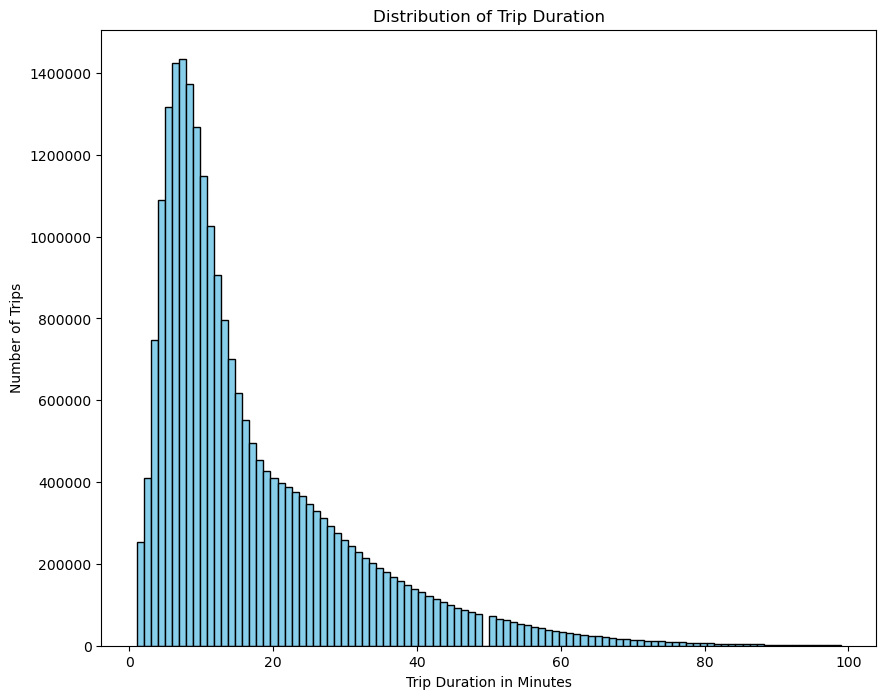

In [59]:
plt.figure(figsize=(10, 8))
plt.hist(taxi_trips_minutes_df[taxi_trips_minutes_df < 100], bins=100, color="skyblue", edgecolor="black")
plt.ticklabel_format(style='plain', axis='y')
plt.xlabel("Trip Duration in Minutes")
plt.ylabel("Number of Trips")
plt.title("Distribution of Trip Duration")
plt.show()

In [60]:
pd.options.display.float_format = '{:.2f}'.format
taxi_trips_minutes_df.describe()

count   23965672.00
mean          17.89
std           28.40
min            1.00
25%            7.00
50%           12.00
75%           23.00
max         1440.00
Name: trip_minutes, dtype: float64

**Summary:** The distribution of taxi trip duration is right-skewed. Most trips are between 1 and 23 minutes. The median duration is 12 minutes but the mean duration is 17.89 minutes, suggesting most trips take a short time but some large outliers are pulling up the mean.

### 4.2 What is the distribution of trip distance?

In [62]:
taxi_trips_distance_df = taxi_trips.select(col("trip_miles")).toPandas()["trip_miles"]

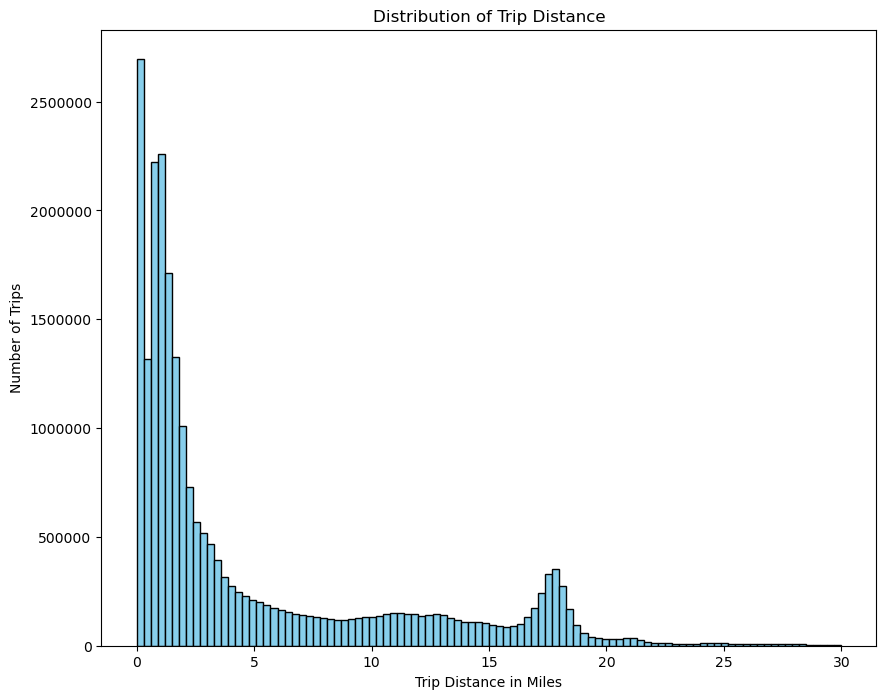

In [63]:
plt.figure(figsize=(10, 8))
plt.hist(taxi_trips_distance_df[taxi_trips_distance_df < 30], bins=100, color="skyblue", edgecolor="black")
plt.ticklabel_format(style='plain', axis='y')
plt.xlabel("Trip Distance in Miles")
plt.ylabel("Number of Trips")
plt.title("Distribution of Trip Distance")
plt.show()

In [64]:
taxi_trips_distance_df.describe()

count   23965672.00
mean           5.17
std            7.45
min            0.00
25%            0.81
50%            1.90
75%            7.89
max         3430.53
Name: trip_miles, dtype: float64

**Summary:** The distribution for taxi trip distance is right-skewed. At least 50% of the total trip having a distance less than 2 miles, while mean distance is 5.17 miles, suggesting that there are many shot trips and a smaller number of very long trips pulling the mean upward. There is a small local manimum at around 16 to 20 miles, which may indicate inter-city trips where the pickup or dropoff location is outside of Chicago which result in longer trips.

### 4.3 What is the distribution of trip fare?

In [65]:
taxi_trips_fare_df = taxi_trips.select(col("fare")).toPandas()["fare"]

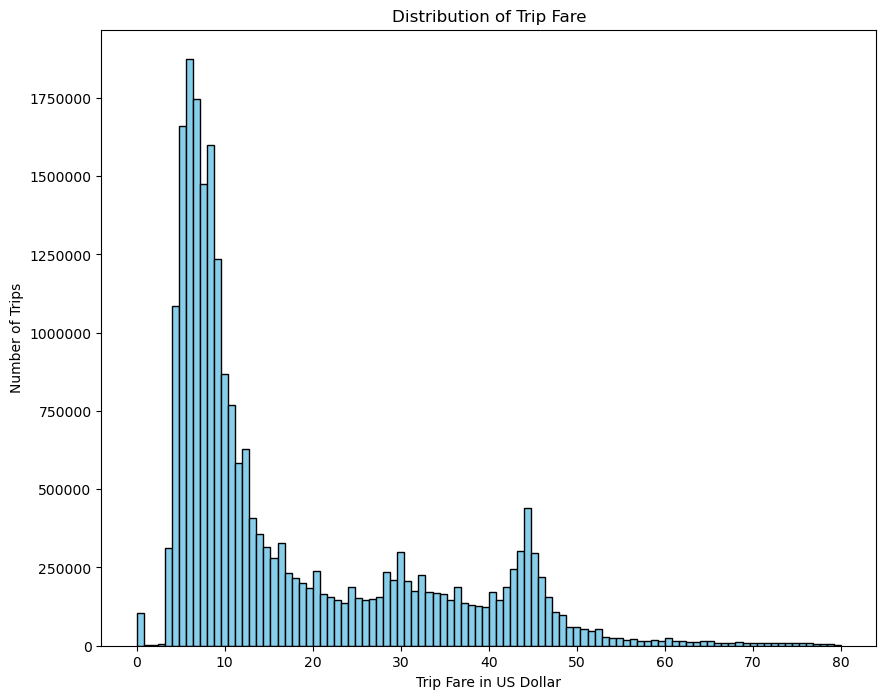

In [66]:
plt.figure(figsize=(10, 8))
plt.hist(taxi_trips_fare_df[taxi_trips_fare_df < 80], bins=100, color="skyblue", edgecolor="black")
plt.ticklabel_format(style='plain', axis='y')
plt.xlabel("Trip Fare in US Dollar")
plt.ylabel("Number of Trips")
plt.title("Distribution of Trip Fare")
plt.show()

In [67]:
taxi_trips_fare_df.describe()

count   23965672.00
mean          18.34
std           55.45
min            0.00
25%            6.75
50%           10.50
75%           27.25
max         9900.26
Name: fare, dtype: float64

**Summary:** The distribution of fares for Chicago taxi trip is right-skewed. The majority of trips cost between 0 USD (indicatng that the trip may have been cancelled) and 28 USD. The median fare is 10.50 USD while the mean fare is 18.34 USD, suggesting that most trips cost somewhere around 10.50 USD but there are smaller of trips with more expensive fares that are pulling up the average. This may indicate a longer trip (for example, inter-city trip), as we also see in the trip distance distribution graph.

### 4.4 How does the number of taxi rides, taxi cars, and taxi companies changes across the years from 2018 to 2023?

We deem the trip start year to be the grouping factor for counting taxi cars in each year. Trips whose start year and end year is different (e.g. trips on New Year's Eve) will be counted to the start year.

In [68]:
from pyspark.sql.functions import year, countDistinct

df_with_year = taxi_trips.withColumn("year", year(taxi_trips["trip_start_timestamp"]))

trip_count_per_year = (
    df_with_year.groupBy("year")                      
                 .agg(countDistinct("trip_id").alias("unique_trip_count"))
                 .orderBy("year", ascending=True)
)

taxi_count_per_year = (
    df_with_year.groupBy("year")                      
                 .agg(countDistinct("taxi_id").alias("unique_taxi_count"))
                 .orderBy("year", ascending=True)
)

company_count_per_year = (
    df_with_year.groupBy("year")                      
                 .agg(countDistinct("company").alias("unique_company_count"))
                 .orderBy("year", ascending=True)
)

In [69]:
trip_count_per_year_pd = trip_count_per_year.toPandas()
taxi_count_per_year_pd = taxi_count_per_year.toPandas()
company_count_per_year_pd = company_count_per_year.toPandas()

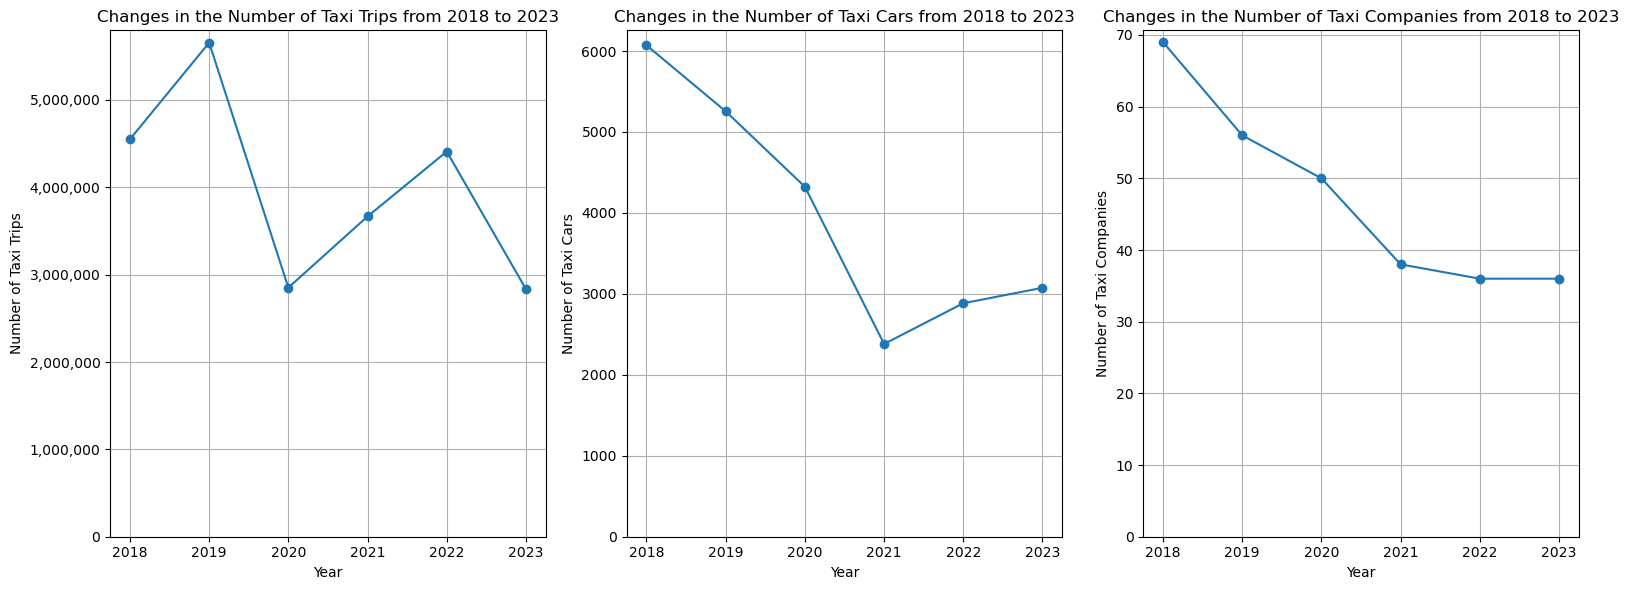

In [70]:
from matplotlib.ticker import StrMethodFormatter

fig, axes = plt.subplots(1, 3, figsize=(16,6), sharey=False)

axes[0].plot(trip_count_per_year_pd["year"], trip_count_per_year_pd["unique_trip_count"], marker='o', linestyle='-')
axes[0].set_xlabel("Year")
axes[0].set_ylabel("Number of Taxi Trips")
axes[0].set_title("Changes in the Number of Taxi Trips from 2018 to 2023")
axes[0].set_ylim(bottom=0)
axes[0].yaxis.set_major_formatter(StrMethodFormatter("{x:,.0f}"))
axes[0].grid()

axes[1].plot(taxi_count_per_year_pd["year"], taxi_count_per_year_pd["unique_taxi_count"], marker='o', linestyle='-')
axes[1].set_xlabel("Year")
axes[1].set_ylabel("Number of Taxi Cars")
axes[1].set_title("Changes in the Number of Taxi Cars from 2018 to 2023")
axes[1].set_ylim(bottom=0) 
axes[1].grid()

axes[2].plot(company_count_per_year_pd["year"], company_count_per_year_pd["unique_company_count"], marker='o', linestyle='-')
axes[2].set_xlabel("Year")
axes[2].set_ylabel("Number of Taxi Companies")
axes[2].set_title("Changes in the Number of Taxi Companies from 2018 to 2023")
axes[2].set_ylim(bottom=0) 
axes[2].grid()

plt.tight_layout()
plt.show()

**Summary:** The graphs above compare the trends of taxi trips, taxi cars, and taxi companies over time. We can see that the number of taxi cars and taxi companies following similr trends where it continue to decrease from 2019 to 2021, which the trends for taxi trip counts is less predictable. The first case of COVID-19 is recorded at the beginning of 2020, followed by strict travel restrictions and statewide stay-at-home order in the state of Illinois that extends through May 2020 and stay-at-home advisory from November 2020 through December 2020 significantly affects the taxi trip demands, which explains the sharp drop from 2019 to 2020. The trip demands, however, makes a turnaround in 2021 and continue to increase in 2022 after the restriction is lifted and COVID-19 policy shift toward vacination, although it doesn't recover to the same height as in 2019 before COVID-19. The number of taxi cars and companies drops in 2020 also continue to decrease even after the restriction is lifted, which is possibly due to taxi drivers switching careers after experiencing poor demand in the previous years and competitions from Rideshare apps. Taxi companies may have shut down due to profit loss and industry's unsustainability in the face of Rideshare app's rising popularity.

**Summary:** There is a sharp drop in the number of taxi companies in Chicago from 2018 to 2021, and the number continue to decrease albeit at a more gradual pace from 2021 onward.

### 4.5 What is the correlation between duration and distance of taxi trips?

In [71]:
taxi_trips_miles_minutes = taxi_trips[['trip_miles', 'trip_minutes']]

In [72]:
taxi_trips_miles_minutes = taxi_trips_miles_minutes.na.drop(subset=['trip_miles'])
df_miles_minutes = taxi_trips_miles_minutes.toPandas()
df_miles_minutes = df_miles_minutes[(df_miles_minutes["trip_miles"] > 0) & (df_miles_minutes["trip_miles"] <= 100)]

In [73]:
correlation = df_miles_minutes['trip_minutes'].corr(df_miles_minutes['trip_miles'])
print(f"Correlation between trip duration and trip distance is {correlation:.2f}.")

Correlation between trip duration and trip distance is 0.42.


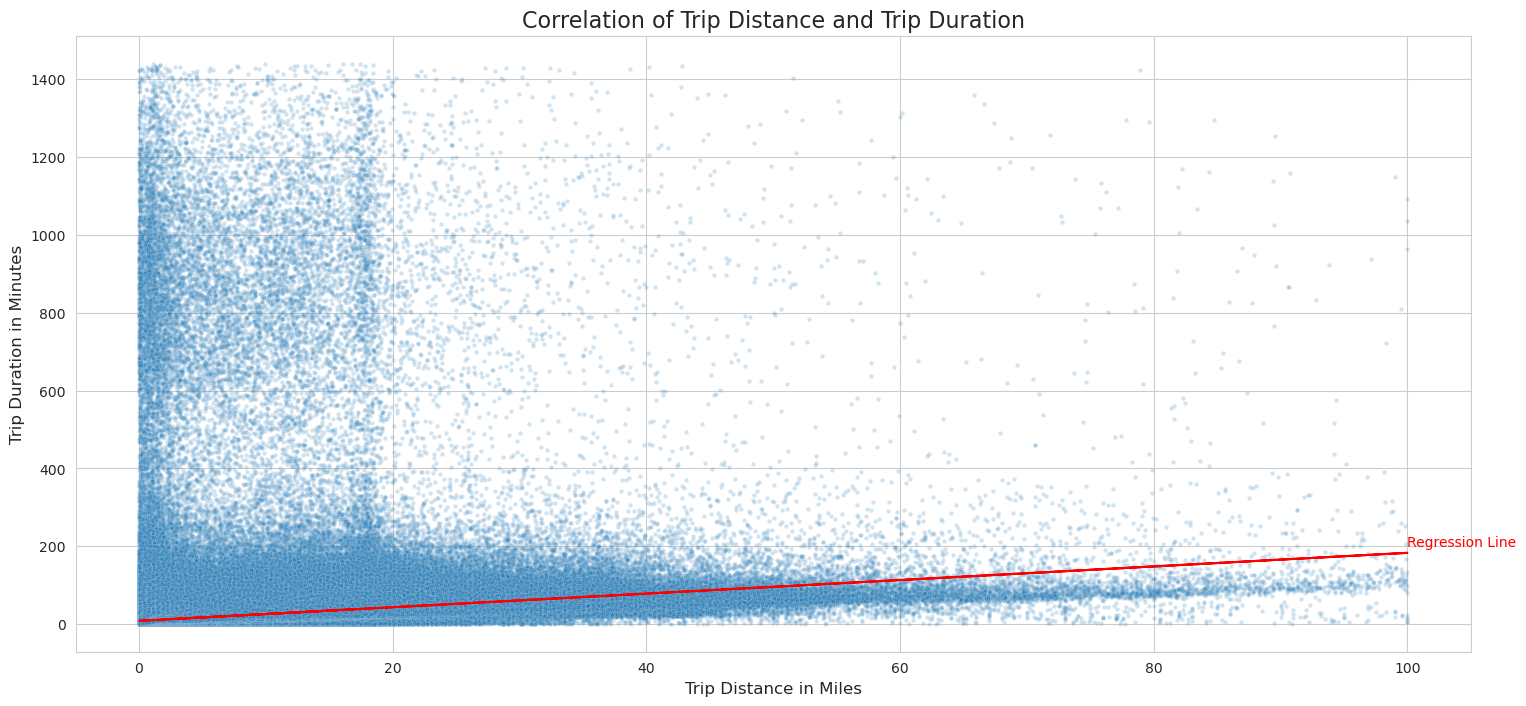

In [74]:
sns.set_style("whitegrid")

plt.figure(figsize=(18, 8))
coefficients = np.polyfit(df_miles_minutes['trip_miles'], df_miles_minutes['trip_minutes'], 1)
linear_fit = np.poly1d(coefficients)

sns.scatterplot(data=df_miles_minutes, x='trip_miles', y='trip_minutes', s=10, alpha=0.2)
plt.plot(df_miles_minutes['trip_miles'], linear_fit(df_miles_minutes['trip_miles']), color='red')

plt.text(100, 200, "Regression Line", color="red")

plt.title('Correlation of Trip Distance and Trip Duration', fontsize=16)
plt.xlabel('Trip Distance in Miles', fontsize=12)
plt.ylabel('Trip Duration in Minutes', fontsize=12)

plt.show()

**Summary:** The scatter plot shows that there is some linear relationship between trip distance and duration, but there are many datapoints that lies further away from the line especially in the case where the distance is shot. A moderate correlation of 0.42 indicated that in general, trip duration increases when the distance increases. However, the correlation is not particularly strong, which suggests that there may be external influence, such as traffic and weather condition or highways, that cause the trip to become shorter or longer than expected.

### 4.6 What is the correlation between trip distance and fare?

In [75]:
taxi_trips_miles_fare = taxi_trips[['trip_miles', 'fare']]

In [76]:
taxi_trips_miles_fare = taxi_trips_miles_fare.na.drop(subset=['trip_miles'])
df_miles_fare = taxi_trips_miles_fare.toPandas()
df_miles_fare = df_miles_fare[(df_miles_fare["trip_miles"] > 0) & (df_miles_fare["trip_miles"] <= 100) & (df_miles_fare["fare"] <= 1000)]

In [77]:
correlation = df_miles_fare['fare'].corr(df_miles_fare['trip_miles'])
print(f"Correlation between fare and trip_miles: {correlation:.2f}")

Correlation between fare and trip_miles: 0.90


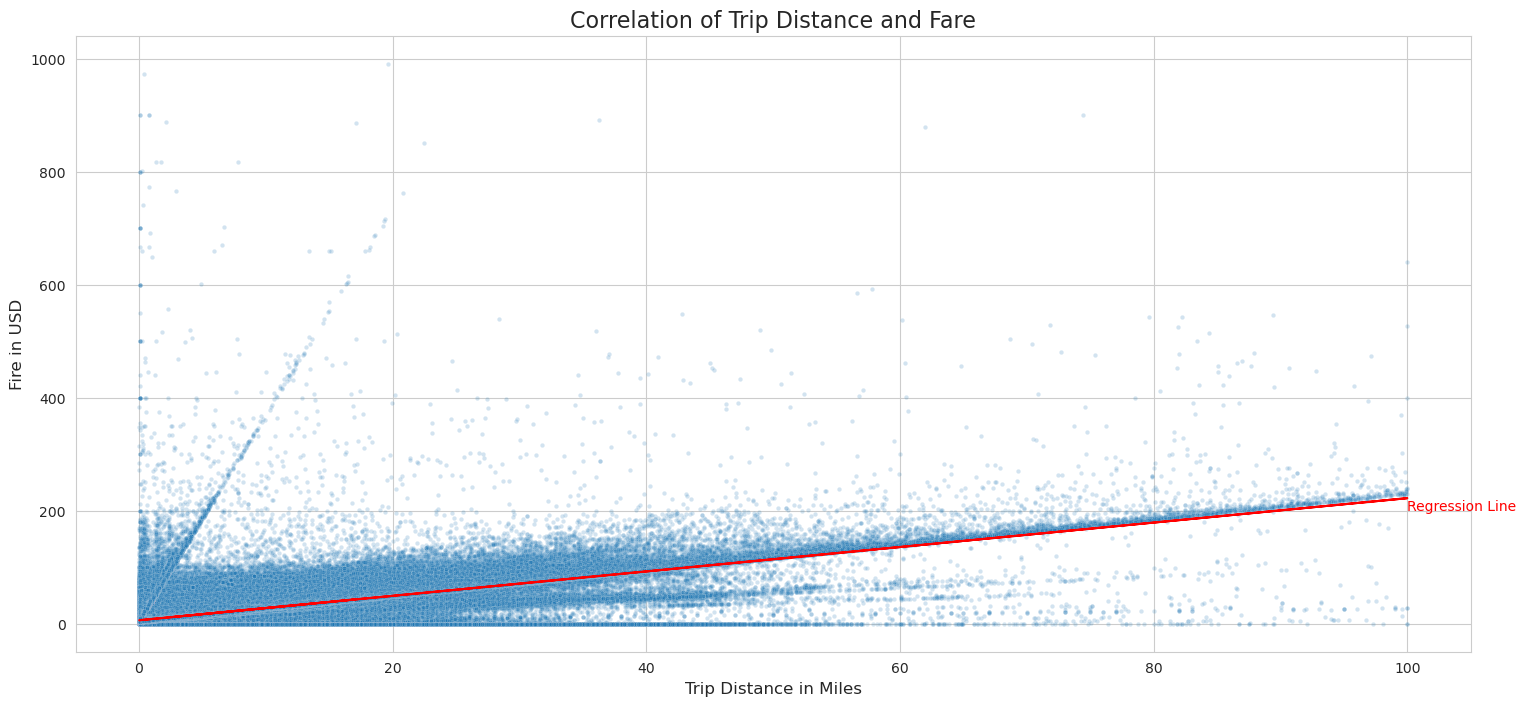

In [78]:
import matplotlib as mpl

sns.set_style("whitegrid")

plt.figure(figsize=(18, 8))
coefficients = np.polyfit(df_miles_fare['trip_miles'], df_miles_fare['fare'], 1)
linear_fit = np.poly1d(coefficients)

sns.scatterplot(data=df_miles_fare, x='trip_miles', y='fare', s=10, alpha=0.2)
plt.plot(df_miles_fare['trip_miles'], linear_fit(df_miles_fare['trip_miles']), color='red')

plt.text(100, 200, "Regression Line", color="red")

plt.title('Correlation of Trip Distance and Fare', fontsize=16)
plt.xlabel('Trip Distance in Miles', fontsize=12)
plt.ylabel('Fire in USD', fontsize=12)

plt.show()

**Summary:** The scatter plot and the correlation score of 0.90 indicates that there is a very strong linear relationship between trip distance and duration. Trip fare increases as the distance increases. Trips where the fare is higher than typical of the distance indicates that traffic conditions may cause the charges to go up while distance remains the same.

## 5. Taxi Hotspot Analysis <a class="anchor" id="5"></a>
---

In [79]:
import geopandas as gpd
from shapely.wkt import loads
from matplotlib.colors import Normalize
import matplotlib.colorbar as mcolorbar
import matplotlib.cm as cm
from matplotlib.ticker import FuncFormatter
from matplotlib.patches import Patch

Chicago city is divided into 77 community areaa, which is given by the community area dataset.

Remove AREA_NUMBER -1 because it doesn't contain geographical data and will cause error when plotting a map.

In [80]:
community_areas_pd = community_areas.where(~col("the_geom").isNull()).toPandas()

In [81]:
community_areas_pd["geometry"] = community_areas_pd["the_geom"].apply(loads)
gdf = gpd.GeoDataFrame(community_areas_pd, geometry="geometry")
gdf.set_crs(epsg=4326, inplace=True)

,the_geom,AREA_NUMBER,COMMUNITY,SHAPE_AREA,SHAPE_LEN,geometry
0,MULTIPOLYGON (((-87.60914087617894 41.84469250...,35,DOUGLAS,46004621.1581,31027.0545098,"MULTIPOLYGON (((-87.60914 41.84469, -87.60915 ..."
1,MULTIPOLYGON (((-87.59215283879394 41.81692934...,36,OAKLAND,16913961.0408,19565.5061533,"MULTIPOLYGON (((-87.59215 41.81693, -87.59231 ..."
2,MULTIPOLYGON (((-87.62879823733725 41.80189303...,37,FULLER PARK,19916704.8692,25339.0897503,"MULTIPOLYGON (((-87.62880 41.80189, -87.62879 ..."
3,MULTIPOLYGON (((-87.6067081256125 41.816813770...,38,GRAND BOULEVARD,48492503.1554,28196.8371573,"MULTIPOLYGON (((-87.60671 41.81681, -87.60670 ..."
4,MULTIPOLYGON (((-87.59215283879394 41.81692934...,39,KENWOOD,29071741.9283,23325.1679062,"MULTIPOLYGON (((-87.59215 41.81693, -87.59215 ..."
...,...,...,...,...,...,...
72,MULTIPOLYGON (((-87.69645961375822 41.70714491...,74,MOUNT GREENWOOD,75584290.0209,48665.1305392,"MULTIPOLYGON (((-87.69646 41.70714, -87.69644 ..."
73,MULTIPOLYGON (((-87.64215204651398 41.68508211...,75,MORGAN PARK,91877340.6988,46396.419362,"MULTIPOLYGON (((-87.64215 41.68508, -87.64249 ..."
74,MULTIPOLYGON (((-87.83658087874365 41.98639611...,76,OHARE,371835607.687,173625.98466,"MULTIPOLYGON (((-87.83658 41.98640, -87.83658 ..."
75,MULTIPOLYGON (((-87.65455590025104 41.99816614...,77,EDGEWATER,48449990.8397,31004.8309456,"MULTIPOLYGON (((-87.65456 41.99817, -87.65456 ..."


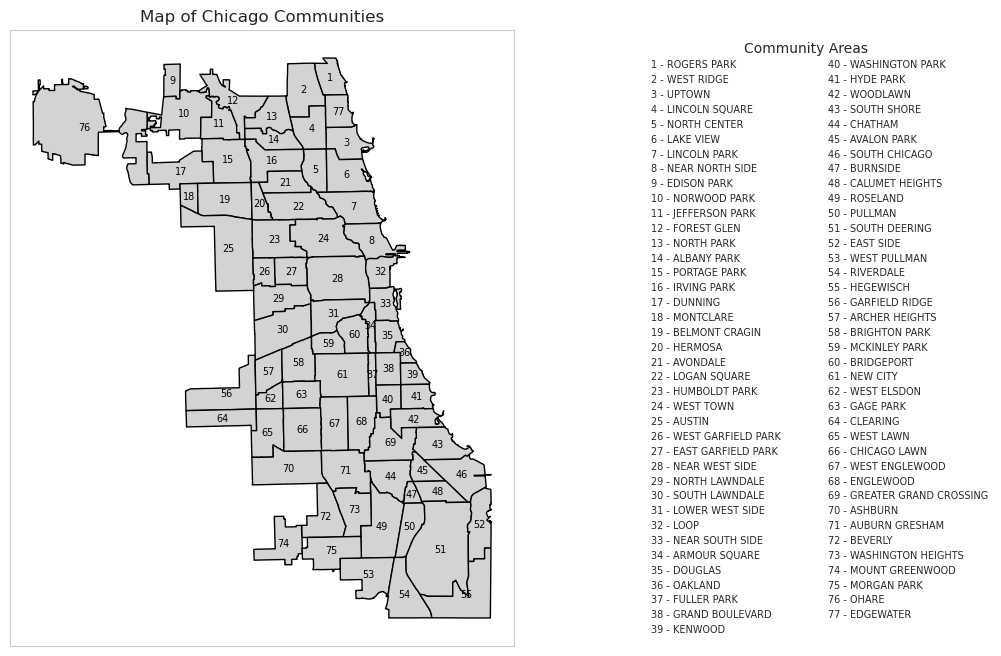

In [82]:
gdf = gdf.sort_values(by="AREA_NUMBER")

fig, ax = plt.subplots(figsize=(10,8))
gdf.plot(
    color="lightgray",
    edgecolor="black",
    ax=ax
)

for _, row in gdf.iterrows():
    centroid = row.geometry.centroid
    ax.text(
        centroid.x, centroid.y,
        str(row["AREA_NUMBER"]),
        fontsize=7,
        color="black",
        ha="center",
        va="center",
    )

# Prepare legend handles
legend_handles = [
    Patch(color="none", label=f"{row['AREA_NUMBER']} - {row['COMMUNITY']}") 
    for _, row in gdf.iterrows()
]

# Add the legend with multiple columns
ax.legend(
    handles=legend_handles,
    title="Community Areas",
    loc="center left",
    bbox_to_anchor=(1.2, 0.5),
    ncol=2,
    fontsize=7,
    title_fontsize=10,
    frameon=False
)

# Add title and axis labels
ax.set_title("Map of Chicago Communities", fontsize=12)
ax.set_xticks([])
ax.set_yticks([])
ax.grid(False)

plt.show()

### 5.1 Which locations see a large demand in taxi pickups and dropoffs?

In [83]:
taxi_pickup_community_area = taxi_trips.groupBy("pickup_community_area").count().withColumnRenamed("count", "ride_frequency").toPandas()
taxi_pickup_community_area_gdf = gdf.merge(taxi_pickup_community_area, left_on="AREA_NUMBER", right_on="pickup_community_area", how="inner")

In [84]:
taxi_pickup_community_area_gdf.sort_values(by="ride_frequency", ascending=False).head(5)

,the_geom,AREA_NUMBER,COMMUNITY,SHAPE_AREA,SHAPE_LEN,geometry,pickup_community_area,ride_frequency
7,MULTIPOLYGON (((-87.62446476694345 41.91156699...,8,NEAR NORTH SIDE,76675895.9728,57293.1649516,"MULTIPOLYGON (((-87.62446 41.91157, -87.62459 ...",8,5883327
31,MULTIPOLYGON (((-87.6094858028664 41.889399110...,32,LOOP,46335565.4586,39428.6729962,"MULTIPOLYGON (((-87.60949 41.88940, -87.60949 ...",32,4529176
75,MULTIPOLYGON (((-87.83658087874365 41.98639611...,76,OHARE,371835607.687,173625.98466,"MULTIPOLYGON (((-87.83658 41.98640, -87.83658 ...",76,2784594
27,MULTIPOLYGON (((-87.6375883858287 41.886234136...,28,NEAR WEST SIDE,158492466.554,53003.5929406,"MULTIPOLYGON (((-87.63759 41.88623, -87.63765 ...",28,2135936
5,MULTIPOLYGON (((-87.64102430213292 41.95480280...,6,LAKE VIEW,87214799.2728,51973.0968677,"MULTIPOLYGON (((-87.64102 41.95480, -87.64101 ...",6,809968


In [85]:
taxi_dropoff_community_area = taxi_trips.groupBy("dropoff_community_area").count().withColumnRenamed("count", "ride_frequency").toPandas()
taxi_dropoff_community_area_gdf = gdf.merge(taxi_dropoff_community_area, left_on="AREA_NUMBER", right_on="dropoff_community_area", how="inner")

In [86]:
taxi_dropoff_community_area_gdf.sort_values(by="ride_frequency", ascending=False).head(5)

,the_geom,AREA_NUMBER,COMMUNITY,SHAPE_AREA,SHAPE_LEN,geometry,dropoff_community_area,ride_frequency
7,MULTIPOLYGON (((-87.62446476694345 41.91156699...,8,NEAR NORTH SIDE,76675895.9728,57293.1649516,"MULTIPOLYGON (((-87.62446 41.91157, -87.62459 ...",8,5778181
31,MULTIPOLYGON (((-87.6094858028664 41.889399110...,32,LOOP,46335565.4586,39428.6729962,"MULTIPOLYGON (((-87.60949 41.88940, -87.60949 ...",32,3951414
27,MULTIPOLYGON (((-87.6375883858287 41.886234136...,28,NEAR WEST SIDE,158492466.554,53003.5929406,"MULTIPOLYGON (((-87.63759 41.88623, -87.63765 ...",28,2201751
5,MULTIPOLYGON (((-87.64102430213292 41.95480280...,6,LAKE VIEW,87214799.2728,51973.0968677,"MULTIPOLYGON (((-87.64102 41.95480, -87.64101 ...",6,1028970
6,MULTIPOLYGON (((-87.63181810269614 41.93258180...,7,LINCOLN PARK,88316400.4728,49478.4277714,"MULTIPOLYGON (((-87.63182 41.93258, -87.63182 ...",7,928041


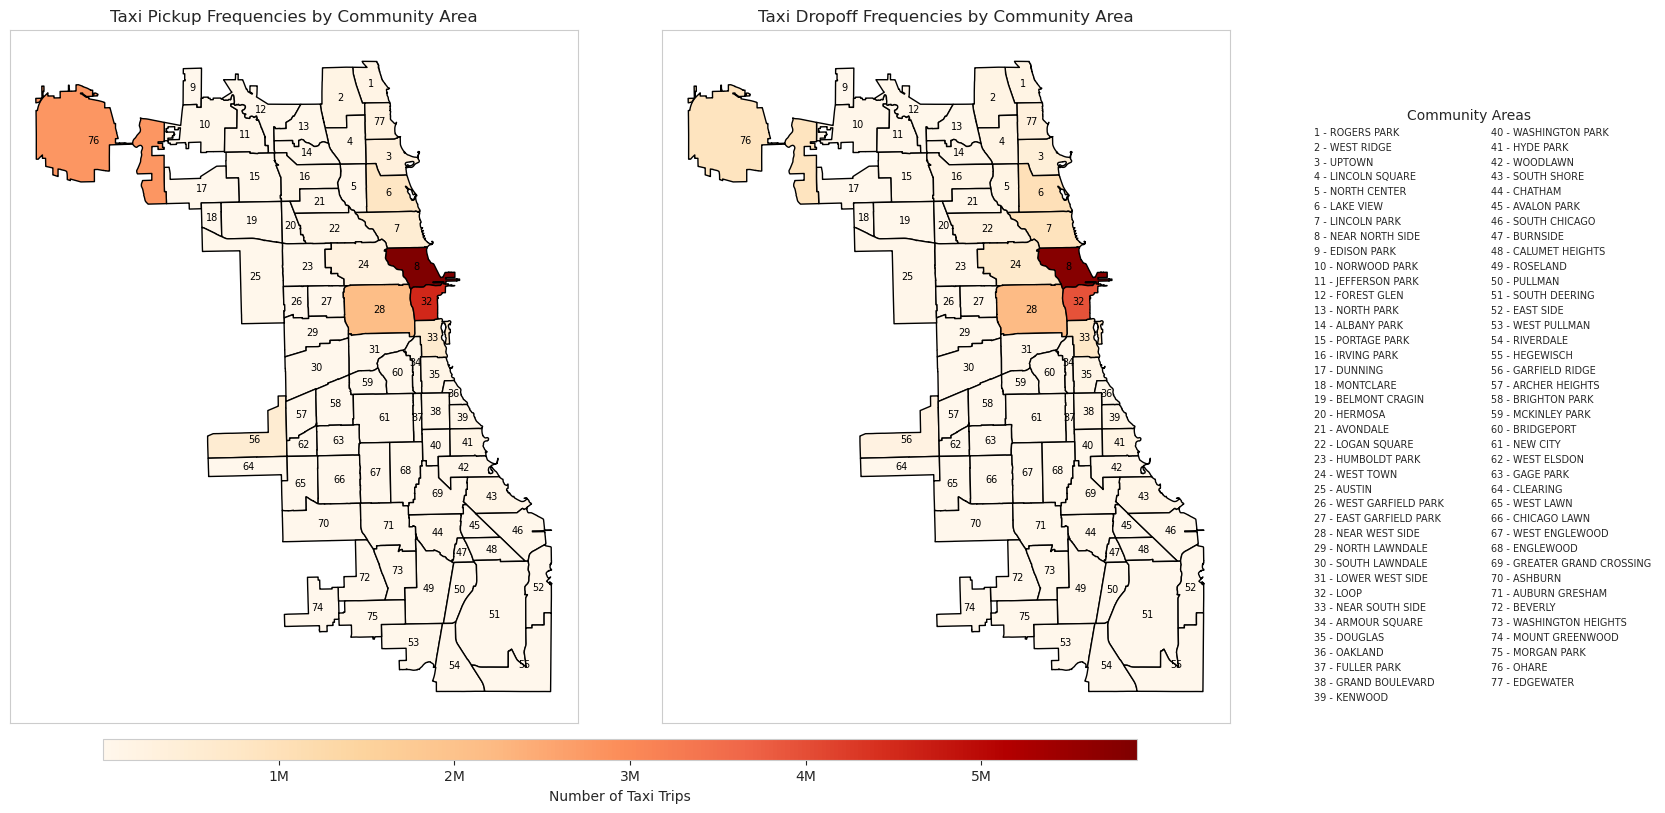

In [87]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.cm as cm
from matplotlib.patches import Patch
from matplotlib.ticker import FuncFormatter

# Normalize ride frequencies for shared color scale
vmin = min(
    taxi_pickup_community_area_gdf["ride_frequency"].min(),
    taxi_dropoff_community_area_gdf["ride_frequency"].min()
)
vmax = max(
    taxi_pickup_community_area_gdf["ride_frequency"].max(),
    taxi_dropoff_community_area_gdf["ride_frequency"].max()
)
norm = Normalize(vmin=vmin, vmax=vmax)
cmap = plt.cm.OrRd

# Add a color column to both GeoDataFrames
taxi_pickup_community_area_gdf["color"] = taxi_pickup_community_area_gdf["ride_frequency"].apply(lambda x: cmap(norm(x)))
taxi_dropoff_community_area_gdf["color"] = taxi_dropoff_community_area_gdf["ride_frequency"].apply(lambda x: cmap(norm(x)))

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 8), constrained_layout=True)

# Plot Pickup Data
taxi_pickup_community_area_gdf.plot(
    color=taxi_pickup_community_area_gdf["color"],
    edgecolor="black",
    ax=ax1
)
ax1.set_title("Taxi Pickup Frequencies by Community Area", fontsize=12)
ax1.set_xticks([])
ax1.set_yticks([])

for _, row in taxi_pickup_community_area_gdf.iterrows():
    centroid = row.geometry.centroid
    ax1.text(
        centroid.x, centroid.y,
        str(row["AREA_NUMBER"]),
        fontsize=7,
        color="black",
        ha="center",
        va="center"
    )

# Plot Dropoff Data
taxi_dropoff_community_area_gdf.plot(
    color=taxi_dropoff_community_area_gdf["color"],
    edgecolor="black",
    ax=ax2
)
ax2.set_title("Taxi Dropoff Frequencies by Community Area", fontsize=12)
ax2.set_xticks([])
ax2.set_yticks([])

for _, row in taxi_dropoff_community_area_gdf.iterrows():
    centroid = row.geometry.centroid
    ax2.text(
        centroid.x, centroid.y,
        str(row["AREA_NUMBER"]),
        fontsize=7,
        color="black",
        ha="center",
        va="center"
    )

# Add a shared horizontal colorbar
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=[ax1, ax2], orientation="horizontal", pad=0.02, aspect=50, shrink=0.8)
cbar.set_label("Number of Taxi Trips", fontsize=10)
cbar.ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x / 1_000_000:.0f}M"))

# Shared legend for community areas
legend_handles = [
    Patch(color="none", label=f"{row['AREA_NUMBER']} - {row['COMMUNITY']}") 
    for _, row in gdf.iterrows()
]
fig.legend(
    handles=legend_handles,
    title="Community Areas",
    loc="center right",
    bbox_to_anchor=(1.3, 0.5),
    ncol=2,
    fontsize=7,
    title_fontsize=10,
    frameon=False
)

plt.show()

**Summary:** We can see from the heatmap above that Near North Side and Loop have more than 4 million pickups and 4 million drop offs from 2018 to 2023. This makes sense because both areas are the downtown area where business districts and popular tourist attractions are located. Near West side also see significant pickup and dropoff due to it's proximity to downtown and sport stadiums such as the Chicago Bulls and the Chicago Blackhawks. O'Hare sees around 3 million pickups over the 6 years, which makes it the third pickup hotspot in Chicago due to it being where Chicago O'Hare International Airport is located.

### 5.2 How much are traffic in the hotspot areas affected by work commute?

In [88]:
from pyspark.sql.functions import date_format, hour

In [89]:
downtown_pickup_trips = taxi_trips.where((col("pickup_community_area") == 8) | (col("pickup_community_area") == 32))
downtown_pickup_trips = downtown_pickup_trips.withColumn("day_of_week", date_format(col("trip_start_timestamp"), "EEEE")) \
                        .withColumn("hour_of_day", hour(col("trip_start_timestamp")) \
                        .cast(IntegerType()))
workday_downtown_pickup_trips = downtown_pickup_trips.where(col("day_of_week").isin("Monday", "Tuesday", "Wednesday", "Thursday", "Friday"))
workday_downtown_pickup_trips = workday_downtown_pickup_trips.groupBy("hour_of_day").agg(count("*").alias("total_ride_pickups")).orderBy("hour_of_day")

In [90]:
workday_downtown_pickup_trips.show(24)

+-----------+------------------+
|hour_of_day|total_ride_pickups|
+-----------+------------------+
|          0|             91110|
|          1|             60116|
|          2|             38419|
|          3|             30736|
|          4|             30117|
|          5|             48462|
|          6|            104078|
|          7|            233833|
|          8|            374386|
|          9|            400802|
|         10|            399385|
|         11|            473759|
|         12|            517419|
|         13|            523684|
|         14|            530915|
|         15|            566805|
|         16|            645115|
|         17|            701937|
|         18|            672743|
|         19|            545671|
|         20|            394637|
|         21|            316639|
|         22|            266107|
|         23|            184324|
+-----------+------------------+



In [91]:
downtown_dropoff_trips = taxi_trips.where((col("dropoff_community_area") == 8) | (col("dropoff_community_area") == 32))
downtown_dropoff_trips = downtown_dropoff_trips.withColumn("day_of_week", date_format(col("trip_end_timestamp"), "EEEE")) \
                                                .withColumn("hour_of_day", hour(col("trip_end_timestamp")) \
                                                .cast(IntegerType()))
workday_downtown_dropoff_trips = downtown_dropoff_trips.where(col("day_of_week").isin("Monday", "Tuesday", "Wednesday", "Thursday", "Friday"))
workday_downtown_dropoff_trips = workday_downtown_dropoff_trips.groupBy("hour_of_day").agg(count("*").alias("total_ride_dropoffs")).orderBy("hour_of_day")

In [92]:
workday_downtown_dropoff_trips.show(24)

+-----------+-------------------+
|hour_of_day|total_ride_dropoffs|
+-----------+-------------------+
|          0|              95116|
|          1|              61649|
|          2|              34819|
|          3|              21390|
|          4|              15496|
|          5|              24326|
|          6|              78386|
|          7|             237819|
|          8|             444971|
|          9|             510138|
|         10|             466135|
|         11|             471406|
|         12|             509622|
|         13|             512319|
|         14|             501144|
|         15|             497847|
|         16|             526938|
|         17|             563847|
|         18|             563722|
|         19|             475979|
|         20|             362681|
|         21|             297050|
|         22|             249484|
|         23|             174966|
+-----------+-------------------+



In [93]:
workday_downtown_pickup_trips_pd = workday_downtown_pickup_trips.toPandas()
workday_downtown_dropoff_trips_pd = workday_downtown_dropoff_trips.toPandas()

workday_downtown_trips = pd.merge(
    workday_downtown_pickup_trips_pd,
    workday_downtown_dropoff_trips_pd,
    on="hour_of_day",
)

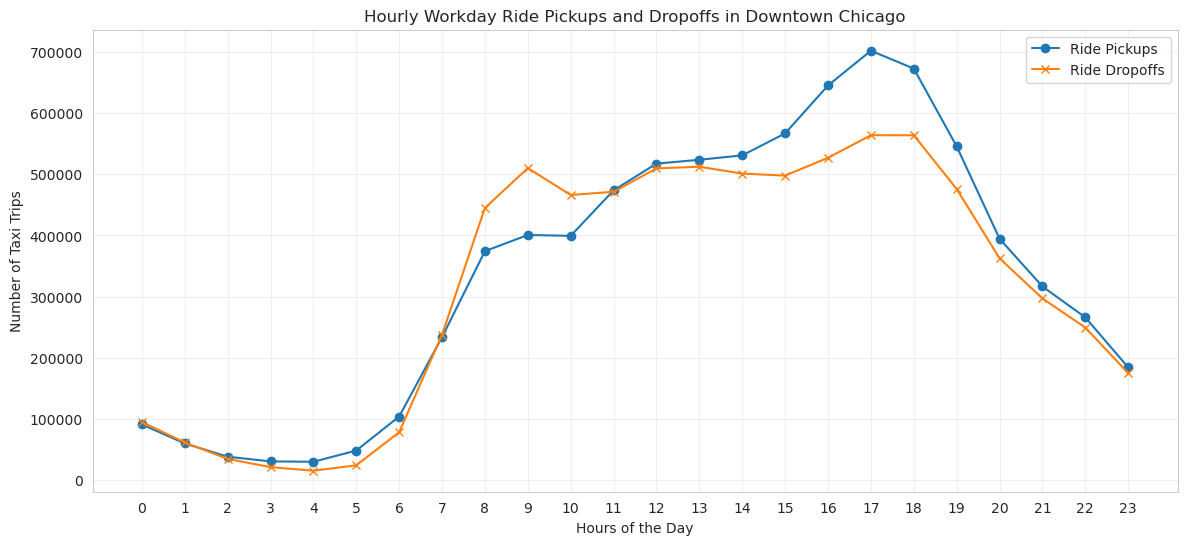

In [94]:
plt.figure(figsize=(14, 6))
plt.plot(workday_downtown_trips['hour_of_day'], workday_downtown_trips['total_ride_pickups'], label='Ride Pickups', marker='o')
plt.plot(workday_downtown_trips['hour_of_day'], workday_downtown_trips['total_ride_dropoffs'], label='Ride Dropoffs', marker='x')

plt.title('Hourly Workday Ride Pickups and Dropoffs in Downtown Chicago')
plt.xlabel('Hours of the Day')
plt.ylabel('Number of Taxi Trips')
plt.xticks(range(0, 24))
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()

**Summary**: Taxi ride demands in Downtown area is significantly affected by work hours. The number of both pickups and dropoffs increases sharply at 6AM and continue to increase at a rapid rate until 8AM, which is the time when commuters leave home for work assuming the regular work hours start at 9AM. The number of taxi pickups and dropoffs remain high during work hours due to visits to different businesses in Downtown. At 4-5PM, taxi pickups peak because it is the time when people leave work and continue decreasing as the time goes on.

## 6. Time Analysis <a class="anchor" id="6"></a>
---

In [95]:
from pyspark.sql.functions import date_format, hour, month, year, dayofmonth

### 6.1 What are the difference in taxi demand based on month of the year, day of the week, and time of the day?

In [96]:
time_trips = (
    taxi_trips \
    .withColumn("year", year(col("trip_start_timestamp"))) \
    .withColumn("month", month(col("trip_start_timestamp"))) \
    .withColumn("day_of_month", dayofmonth(col("trip_start_timestamp"))) \
    .withColumn("day_of_week", date_format(col("trip_start_timestamp"), "EEEE")) \
    .withColumn("hour_of_day", hour(col("trip_start_timestamp")).cast(IntegerType()))
)

month_year_trips_pd = time_trips.groupBy("year", "month") \
    .agg(count("*").alias("total_rides")) \
    .orderBy("year", "month").toPandas()

In [97]:
month_year_trips_pd

,year,month,total_rides
0,2018,1,440548
1,2018,2,401861
2,2018,3,501371
3,2018,4,463480
4,2018,5,453901
...,...,...,...
66,2023,8,69793
67,2023,9,518791
68,2023,10,1299
69,2023,11,5160


In [98]:
month_day_trips_pd = time_trips.groupBy("month", "day_of_month") \
    .agg(count("*").alias("total_rides")) \
    .orderBy("month", "day_of_month").toPandas()

In [99]:
month_day_trips_pd

,month,day_of_month,total_rides
0,1,1,54007
1,1,2,61400
2,1,3,70897
3,1,4,64429
4,1,5,60399
...,...,...,...
361,12,27,56869
362,12,28,55392
363,12,29,51056
364,12,30,58246


In [100]:
day_week_month_trips = time_trips.groupBy("month", "day_of_week").agg(count("*").alias("total_rides")).toPandas()

In [101]:
day_week_month_trips

,month,day_of_week,total_rides
0,9,Saturday,291591
1,8,Thursday,229916
2,3,Monday,273188
3,3,Sunday,206414
4,9,Wednesday,385183
...,...,...,...
79,4,Friday,275488
80,4,Monday,230340
81,4,Sunday,154041
82,4,Tuesday,229900


In [102]:
hour_day_trips = (
    time_trips.groupBy("hour_of_day", "day_of_week")
    .agg(count("*").alias("total_rides"))
    .toPandas()
)

In [103]:
hour_day_trips

,hour_of_day,day_of_week,total_rides
0,4,Wednesday,17299
1,8,Thursday,197752
2,9,Saturday,98168
3,7,Thursday,129746
4,3,Monday,19767
...,...,...,...
163,23,Tuesday,75833
164,23,Saturday,135654
165,14,Friday,246598
166,2,Sunday,90219


In [104]:
day_order = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
hour_of_day = np.arange(24)
month_labels = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
year_labels = np.arange(2018, 2024)

In [105]:
all_years = month_year_trips_pd["year"].unique()
all_months = range(1, 13)

# Create a full index with all combinations of years and months
full_index = pd.MultiIndex.from_product([all_years, all_months], names=["year", "month"])

# Reindex the DataFrame to include all combinations, filling missing values with 0
month_year_trips_full = month_year_trips_pd.set_index(["year", "month"]) \
    .reindex(full_index, fill_value=0) \
    .reset_index()

heatmap_month_year_data = month_year_trips_full.pivot(index="year", columns="month", values="total_rides")
heatmap_day_week_month_data = day_week_month_trips.pivot(index="month", columns="day_of_week", values="total_rides").reindex(columns=day_order)
heatmap_hour_day_data = hour_day_trips.pivot(index="day_of_week", columns="hour_of_day", values="total_rides").reindex(index=day_order)

NameError: name 'heatmap_data' is not defined

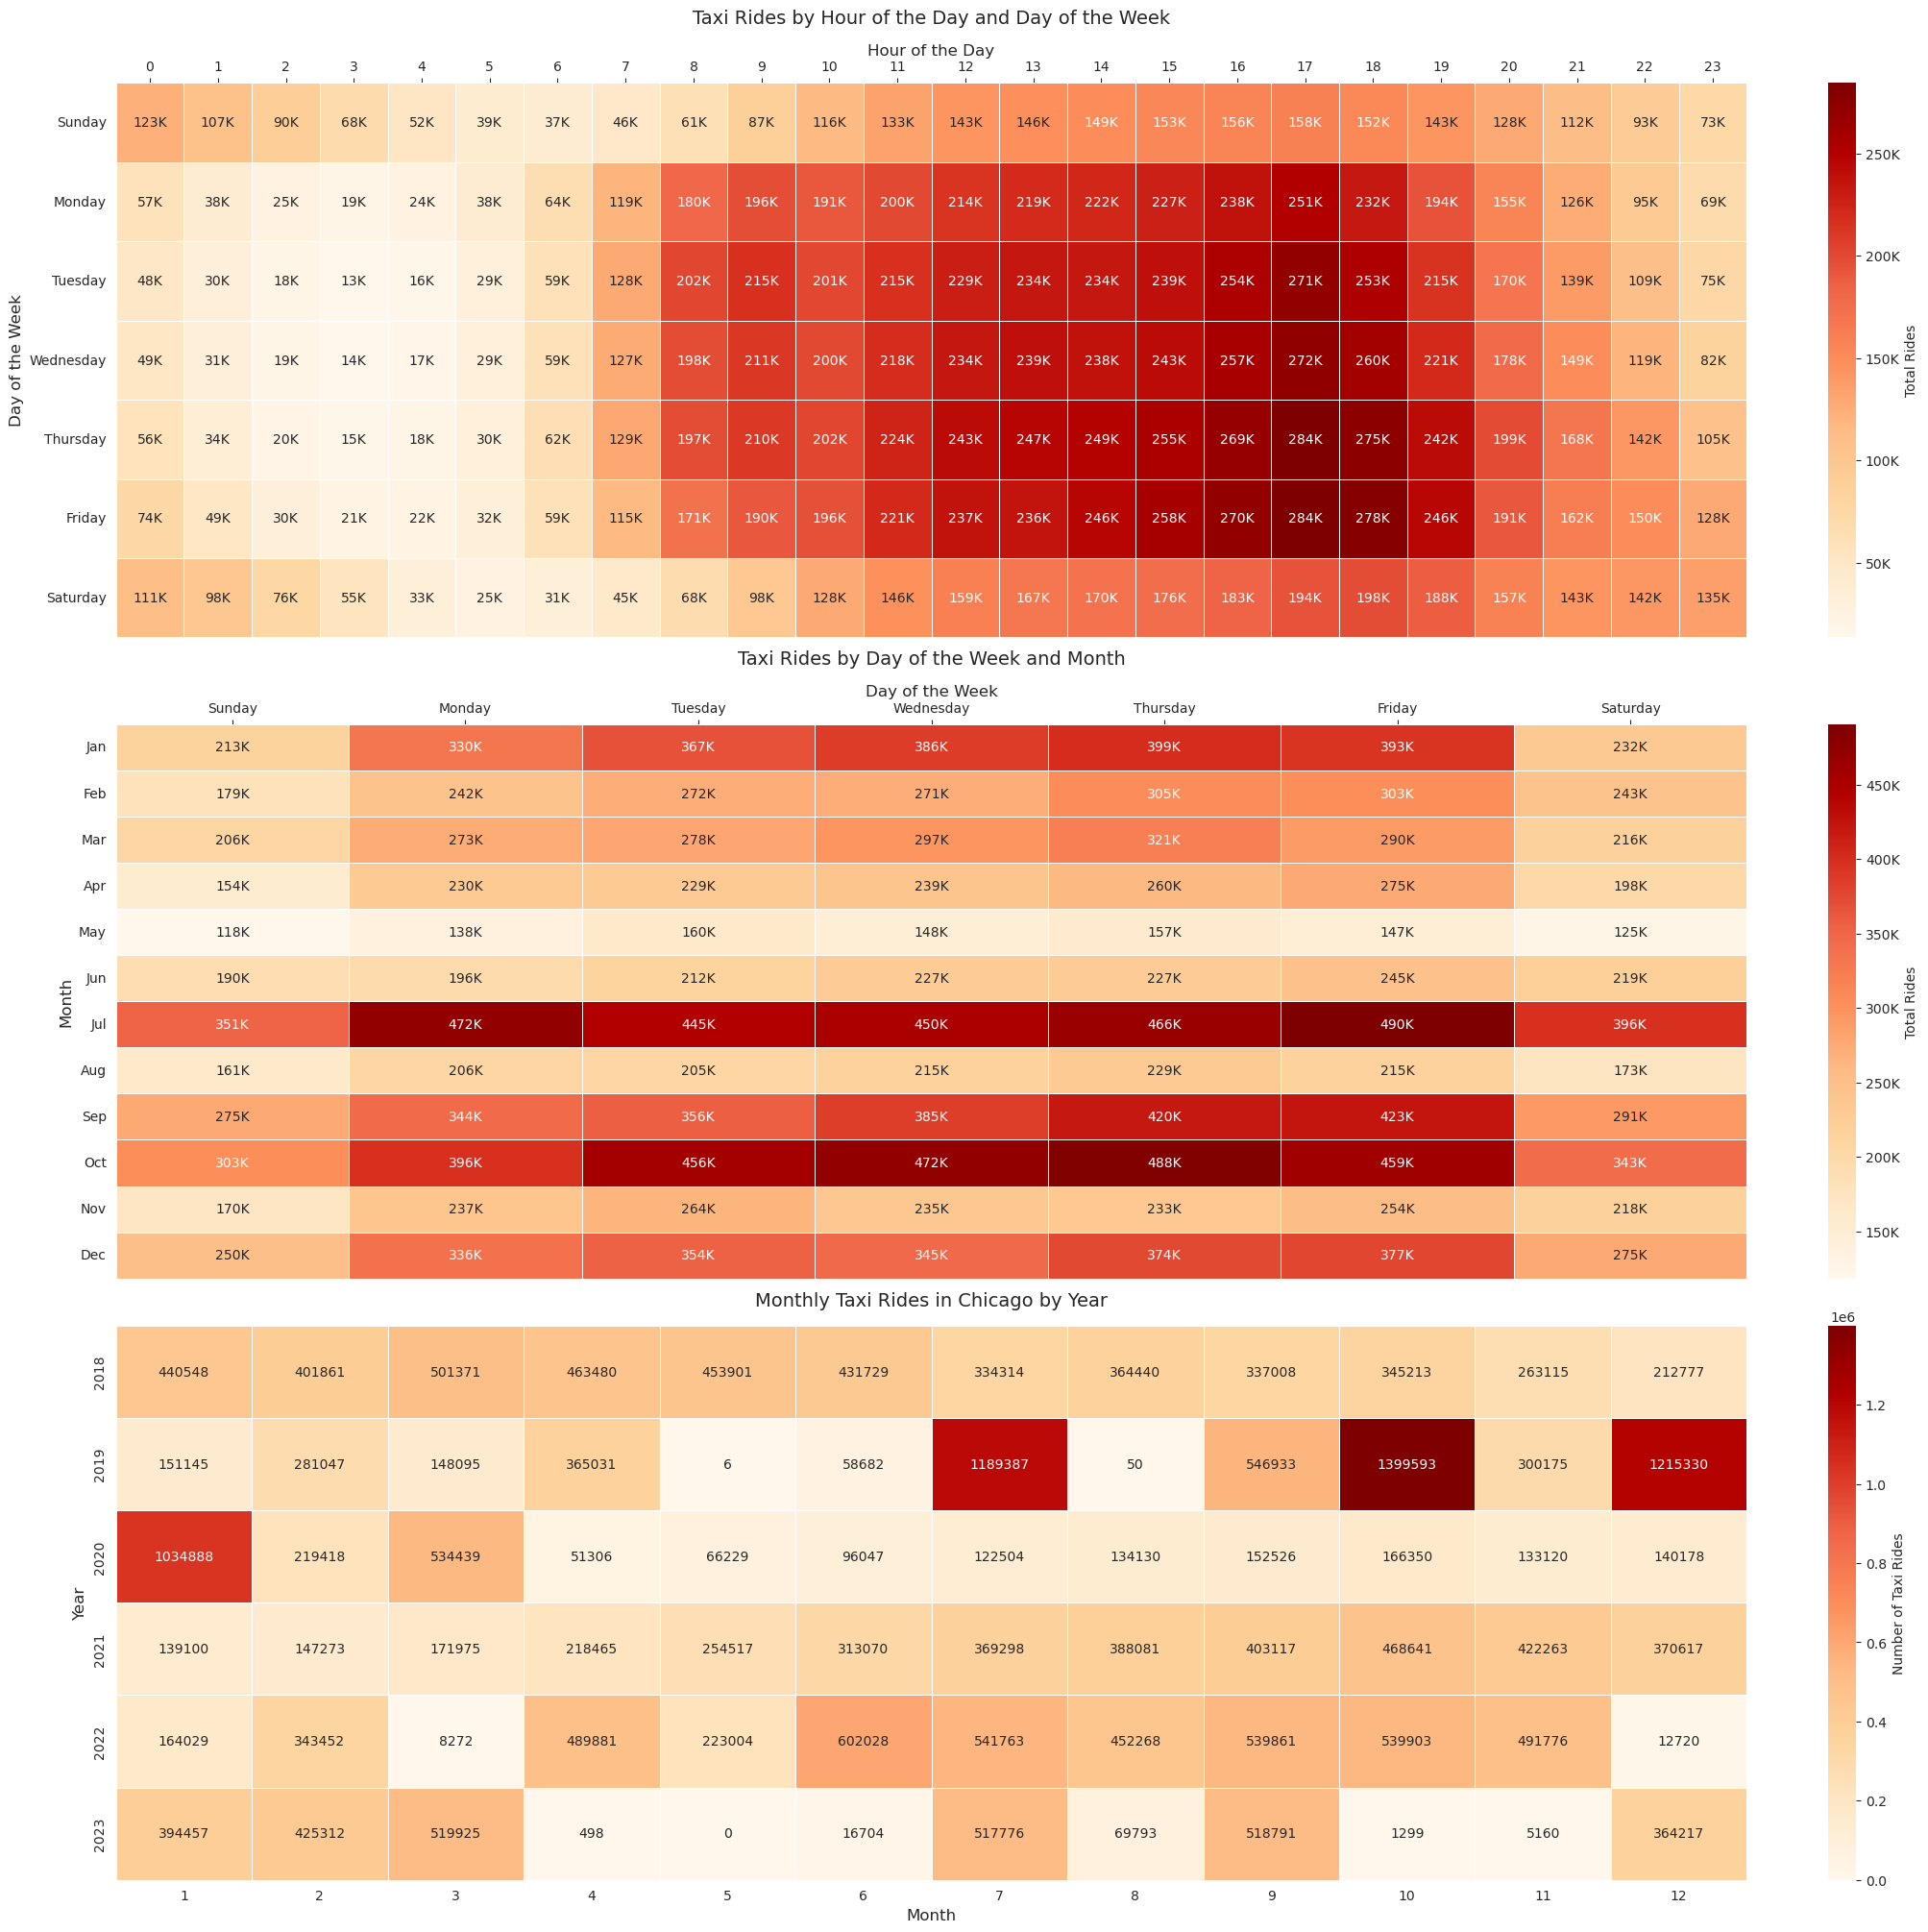

In [106]:
from matplotlib.ticker import FuncFormatter

# Define a function for consistent colorbar formatting
def format_colorbar(cbar_axis):
    cbar_axis.yaxis.set_major_formatter(
        FuncFormatter(
            lambda x, _: f"{int(x / 1000000)}M" if x >= 1000000 else 
            f"{int(x / 1000)}K" if x >= 1000 else 
            f"{int(x)}"
        )
    )

fig, axes = plt.subplots(3, 1, figsize=(20, 20), constrained_layout=True)

# Heatmap 1: Taxi Rides by Hour of the Day and Day of the Week
sns.heatmap(
    heatmap_hour_day_data,
    annot=True,
    fmt=".0f",
    cmap=plt.cm.OrRd,
    linewidths=0.5,
    cbar_kws={"label": "Total Rides"},
    ax=axes[0]
)
axes[0].set_title("Taxi Rides by Hour of the Day and Day of the Week", fontsize=14, pad=15)
axes[0].set_xlabel("Hour of the Day", fontsize=12)
axes[0].set_ylabel("Day of the Week", fontsize=12)
axes[0].tick_params(axis='x', rotation=0)
axes[0].tick_params(axis='y', rotation=0)
axes[0].xaxis.set_label_position('top')
axes[0].xaxis.tick_top()

# Format text annotations and colorbar for heatmap 1
for text in axes[0].texts:
    value = int(text.get_text())
    if value >= 1_000_000:
        text.set_text(f"{value // 1_000_000}M")
    elif value >= 1_000:
        text.set_text(f"{value // 1_000}K")
    else:
        text.set_text(f"{value}")
format_colorbar(plt.gcf().axes[-1])

# Heatmap 2: Taxi Rides by Day of the Week and Month
sns.heatmap(
    heatmap_day_week_month_data,
    annot=True,
    fmt=".0f",
    cmap=plt.cm.OrRd,
    linewidths=0.5,
    cbar_kws={"label": "Total Rides"},
    ax=axes[1]
)
axes[1].set_title("Taxi Rides by Day of the Week and Month", fontsize=14, pad=15)
axes[1].set_xlabel("Day of the Week", fontsize=12)
axes[1].set_ylabel("Month", fontsize=12)
axes[1].set_yticks(np.arange(len(heatmap_day_week_month_data.index)) + 0.5)
axes[1].set_yticklabels(month_labels, rotation=0)
axes[1].xaxis.set_label_position('top')
axes[1].xaxis.tick_top()

# Format text annotations and colorbar for heatmap 2
for text in axes[1].texts:
    value = int(text.get_text())
    if value >= 1_000_000:
        text.set_text(f"{value // 1_000_000}M")
    elif value >= 1_000:
        text.set_text(f"{value // 1_000}K")
    else:
        text.set_text(f"{value}")
format_colorbar(plt.gcf().axes[-1])

# Heatmap 3: Monthly Taxi Rides in Chicago by Year
sns.heatmap(
    heatmap_month_year_data,
    annot=True,
    fmt=".0f",
    cmap=plt.cm.OrRd,
    linewidths=0.5,
    cbar_kws={"label": "Number of Taxi Rides"},
    ax=axes[2]
)
axes[2].set_title("Monthly Taxi Rides in Chicago by Year", fontsize=14, pad=15)
axes[2].set_xlabel("Month", fontsize=12)
axes[2].set_ylabel("Year", fontsize=12)
axes[2].set_xticks(np.arange(len(heatmap_data.columns)) + 0.5)
axes[2].set_xticklabels(month_labels, rotation=0)
axes[2].xaxis.set_label_position('top')
axes[2].xaxis.tick_top()

# Format text annotations and colorbar for heatmap 3
for text in axes[2].texts:
    value = int(text.get_text())
    if value >= 1_000_000:
        text.set_text(f"{value // 1_000_000}M")
    elif value >= 1_000:
        text.set_text(f"{value // 1_000}K")
    else:
        text.set_text(f"{value}")
format_colorbar(plt.gcf().axes[-1])

plt.show()

**Summary:** The heatmaps above shows the number of taxi ride with different datetime scope. The first plot shows taxi rides by time of the day for each day of the week. Thereis a concentration of taxi rides during the work hours on Monday through Friday from 7AM to 7PM, which Friday seeing more rides at night more than other work days which could be attributed to the face that it is the end of a work week. The second plot shows taxi rides by day of the week for each month. Comparing the days in each month, we can see that most rides are concentrated on the work days for every month. July and October seems to see a big surge in taxi rides on weekends. After some research, we found that Chicago hosted several big events in July and October in 2019, including Taste of Chicago, Windy City Smokeout, Pitchfork Music Festival, Bank of America Chicago Marathon, and Open House Chicago, al of which span the weekends. While these events happen every year, some never got back to the same number of participants as before COVID-19, as can be seen from the third plot showing the number of taxi rides by onths for each year from 2018 to 2023.

Note: There are unexplanable drops in the number of taxi rides in multiple months of different years. Notably, in May 2019 where there are only 6 rides recorded and in May 2023 where there is 0 taxi ride recorded. We thinks that it is unlikely that there was 0 rides happening in the entire month. It is more likely that there are data-related issues in months where there are fewer than some thousands taxi rides.

## 7. Congestion Analysis <a class="anchor" id="7"></a>
---

### 7.1 What time of the day is traffic bad?

In [107]:
from pyspark.sql.functions import to_timestamp, hour
extract = taxi_trips.withColumn("hour_of_day", hour("trip_start_timestamp"))

In [115]:
from pyspark.sql.functions import unix_timestamp, col

extract = extract.withColumn("trip_duration_in_seconds", unix_timestamp("trip_end_timestamp") - unix_timestamp("trip_start_timestamp"))
extract = extract.withColumn("trip_duration_in_minutes", col("trip_duration_in_seconds") / 60)

In [116]:
extract

DataFrame[trip_id: string, taxi_id: string, trip_start_timestamp: timestamp, trip_end_timestamp: timestamp, trip_miles: double, pickup_community_area: int, dropoff_community_area: int, fare: double, tips: double, tolls: double, extras: double, trip_total: double, payment_type: string, company: string, trip_minutes: int, hour_of_day: int, trip_duration_in_seconds: bigint, trip_duration_in_minutes: double]

In [117]:
from pyspark.sql.functions import avg

congestion_analysis = extract.groupBy("hour_of_day").agg(
    avg("trip_duration_in_minutes").alias("avg_trip_duration_minutes")
)

congestion_analysis = congestion_analysis.orderBy("avg_trip_duration_minutes", ascending=False)
congestion_analysis.show()



+-----------+-------------------------+
|hour_of_day|avg_trip_duration_minutes|
+-----------+-------------------------+
|         15|       20.620852867076163|
|         16|       20.477196008060364|
|         17|       20.353278087074006|
|         14|       19.325363485227577|
|         18|       18.891237335045208|
|          6|       18.772658067469802|
|          5|       18.605770520536186|
|         13|       18.169218167950298|
|         19|       18.027755981250543|
|         20|        17.86837277144193|
|          7|       17.608637120884914|
|         12|        17.25301024375332|
|         21|       17.049409079892158|
|          8|       16.730581821177005|
|          9|        16.54449526776107|
|         11|       16.491817532368263|
|         10|        16.40644040477273|
|         22|       15.899729264437177|
|         23|       15.769898305488407|
|          0|          15.738213685253|
+-----------+-------------------------+
only showing top 20 rows



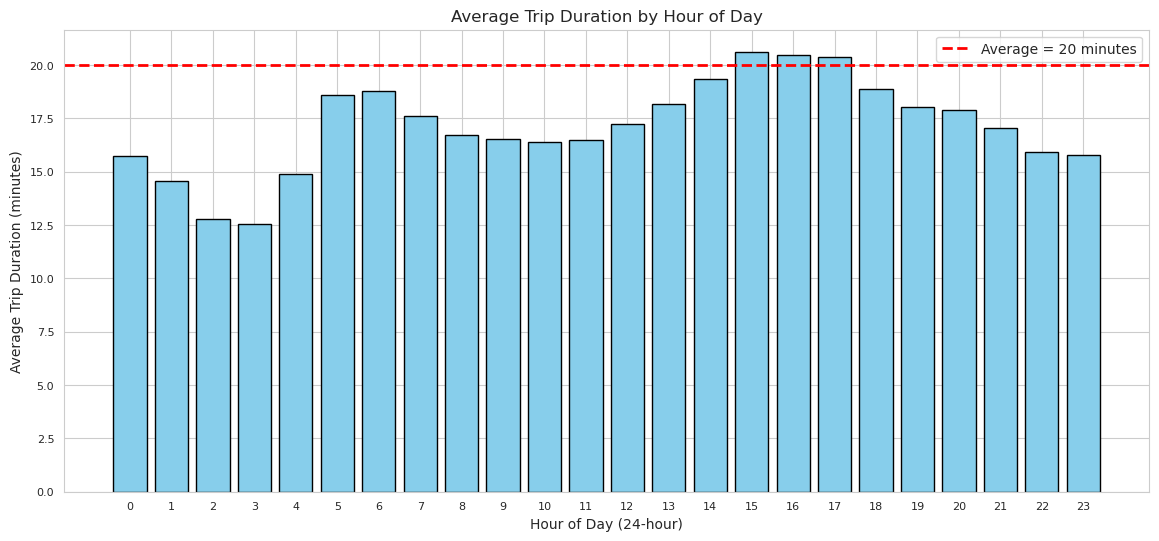

In [143]:
import pandas as pd
import matplotlib.pyplot as plt

congestion_df = congestion_analysis.toPandas()

# bar chart
plt.figure(figsize=(14, 6))
plt.bar(congestion_df['hour_of_day'], congestion_df['avg_trip_duration_minutes'], color='skyblue', edgecolor='black')

# horizontal line at y=20 (average trip duration time)
plt.axhline(y=20, color='red', linestyle='--', linewidth=2, label='Average = 20 minutes')

plt.xlabel('Hour of Day (24-hour)', fontsize=10)
plt.ylabel('Average Trip Duration (minutes)', fontsize=10)
plt.title('Average Trip Duration by Hour of Day', fontsize=12)
plt.xticks(range(24), fontsize=8)
plt.yticks(fontsize=8)

plt.legend()
plt.show()

In [137]:
high_congestion_hours = congestion_analysis.filter(col("avg_trip_duration_minutes") > 20)
high_congestion_hours.show()

+-----------+-------------------------+
|hour_of_day|avg_trip_duration_minutes|
+-----------+-------------------------+
|         15|       20.620852867076163|
|         16|       20.477196008060364|
|         17|       20.353278087074006|
+-----------+-------------------------+



**Summary:** The bar chart displays the average trip duration (in minutes) for each hour of the day, using a 24-hour format. The analysis reveals that the afternoon rush hours—3 PM (15), 4 PM (16), and 5 PM (17)—have the highest average trip durations, indicating the most severe traffic congestion during these times. In contrast, the early morning hours (0–6) show significantly lower trip durations, reflecting lighter traffic conditions. As the day progresses, trip durations steadily increase, peaking in the afternoon before gradually declining after 5 PM.

### 7.2 What location have bad traffic?

In [ ]:
# from pyspark.sql.functions import col, avg

# # Group by pickup location and calculate average trip duration
# bad_traffic_by_location = taxi_trips.groupBy("pickup_community_area") \
#     .agg(avg("trip_minutes").alias("avg_trip_duration_minutes")) \
#     .orderBy(col("avg_trip_duration_minutes").desc())

# # Show top locations with bad traffic
# bad_traffic_by_location.show(10)


+---------------------+-------------------------+
|pickup_community_area|avg_trip_duration_minutes|
+---------------------+-------------------------+
|                   76|        34.14935821882831|
|                   70|       33.667661752162786|
|                   65|        32.75396945410555|
|                   66|        31.12667740203972|
|                   52|       30.970403382470575|
|                   18|       30.384910485933503|
|                   63|       30.065845464725644|
|                   56|       29.400193217157682|
|                   72|        29.08695652173913|
|                   62|        28.67355458150699|
+---------------------+-------------------------+
only showing top 10 rows



In [268]:
from pyspark.sql.functions import col

# Add speed calculation
speed = taxi_trips.withColumn("avg_speed", col("trip_miles") / (col("trip_minutes") / 60))
speed

DataFrame[trip_id: string, taxi_id: string, trip_start_timestamp: timestamp, trip_end_timestamp: timestamp, trip_miles: double, pickup_community_area: int, dropoff_community_area: int, fare: double, tips: double, tolls: double, extras: double, trip_total: double, payment_type: string, company: string, trip_minutes: int, avg_speed: double]

In [ ]:
# # Group by pickup location and find locations with the lowest speeds
# slow_locations = speed.groupBy("pickup_community_area") \
#     .agg(avg("avg_speed").alias("avg_speed")) \
#     .orderBy(col("avg_speed"))
    
# slow_locations.show(10)

+---------------------+------------------+
|pickup_community_area|         avg_speed|
+---------------------+------------------+
|                   32|11.329472645779472|
|                    8|11.432327921166861|
|                   28|11.571505433150413|
|                   20|12.872002094146053|
|                    7| 13.11682951369395|
|                    5|13.578463343252533|
|                   13|13.621762826888464|
|                   63|13.828117385209882|
|                    4|13.973652357155544|
|                    6|14.042700311861822|
+---------------------+------------------+
only showing top 10 rows



In [ ]:
# congested_locations = bad_traffic_by_location.filter(col("avg_trip_duration_minutes") > 30)
# congested_locations.show()

+---------------------+-------------------------+
|pickup_community_area|avg_trip_duration_minutes|
+---------------------+-------------------------+
|                   76|        34.14935821882831|
|                   70|       33.667661752162786|
|                   65|        32.75396945410555|
|                   66|        31.12667740203972|
|                   52|       30.970403382470575|
|                   18|       30.384910485933503|
|                   63|       30.065845464725644|
+---------------------+-------------------------+



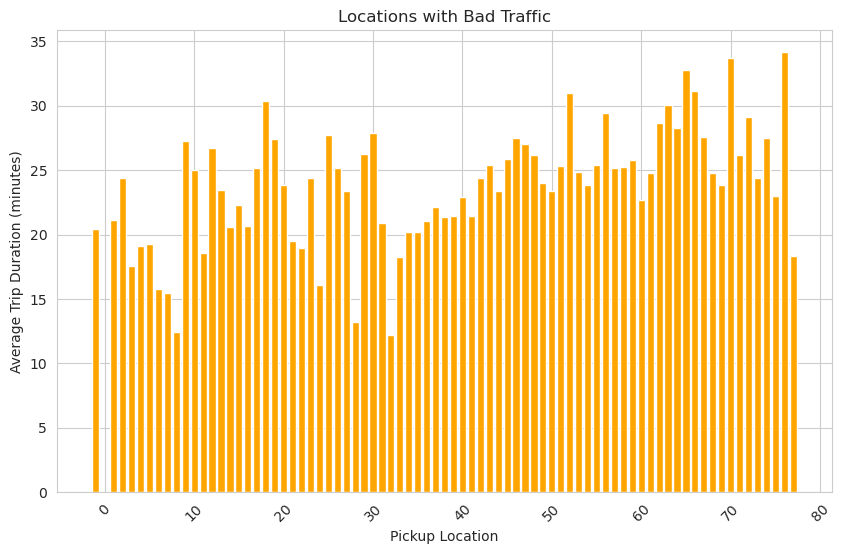

In [ ]:
# import matplotlib.pyplot as plt

# bad_traffic_df = bad_traffic_by_location.toPandas()

# # Plot the locations with the highest average trip duration
# plt.figure(figsize=(10, 6))
# plt.bar(bad_traffic_df['pickup_community_area'], bad_traffic_df['avg_trip_duration_minutes'], color='orange')
# plt.xlabel('Pickup Location')
# plt.ylabel('Average Trip Duration (minutes)')
# plt.title('Locations with Bad Traffic')
# plt.xticks(rotation=45)
# plt.show()

In [289]:
community_copy =  community_areas
speed_droff = speed

In [290]:
speed_droff = speed_droff.withColumnRenamed("dropoff_community_area", "AREA_NUMBER")

In [291]:
combined_df = speed_droff.join(
    community_copy,
    speed_droff["AREA_NUMBER"] == community_copy["AREA_NUMBER"],
    "inner"
).select(
    speed_droff["*"],  # Include all columns from taxi_trips
    community_copy["COMMUNITY"]
 
)

# Show combined result
combined_df.show(10)

+--------------------+--------------------+--------------------+-------------------+----------+---------------------+-----------+-----+-----+-----+------+----------+------------+--------------------+------------+------------------+------------------+
|             trip_id|             taxi_id|trip_start_timestamp| trip_end_timestamp|trip_miles|pickup_community_area|AREA_NUMBER| fare| tips|tolls|extras|trip_total|payment_type|             company|trip_minutes|         avg_speed|         COMMUNITY|
+--------------------+--------------------+--------------------+-------------------+----------+---------------------+-----------+-----+-----+-----+------+----------+------------+--------------------+------------+------------------+------------------+
|fa08ad43dce297f9d...|b56b3188352442603...| 2023-08-22 21:30:00|2023-08-22 21:45:00|     17.04|                   -1|         -1|43.75|  0.0|  0.0|  27.5|     71.75| Credit Card|            Sun Taxi|          26| 39.32307692307692|Outside of Chica

In [292]:
from pyspark.sql.functions import avg, col

# Group by community_name and calculate average trip duration
traffic_by_community = combined_df.groupBy("COMMUNITY","AREA_NUMBER") \
    .agg(avg("trip_minutes").alias("avg_drofftrip_duration")) \
    .orderBy(col("avg_drofftrip_duration").desc())

traffic_by_community.show(10)

+---------------+-----------+----------------------+
|      COMMUNITY|AREA_NUMBER|avg_drofftrip_duration|
+---------------+-----------+----------------------+
|          OHARE|         76|    36.325834945977775|
|      EAST SIDE|         52|     34.37919463087248|
|MOUNT GREENWOOD|         74|     31.20134621012584|
|        BEVERLY|         72|    30.772458812558284|
| GARFIELD RIDGE|         56|    30.672306067847476|
|   CHICAGO LAWN|         66|    30.433278008298757|
|        ASHBURN|         70|    30.415128607893188|
|      MONTCLARE|         18|    30.349991725963925|
|      WEST LAWN|         65|    30.055162514098225|
|      HEGEWISCH|         55|     29.98514625228519|
+---------------+-----------+----------------------+
only showing top 10 rows



In [293]:
traffic_by_community=traffic_by_community.toPandas()
traffic_by_community

,COMMUNITY,AREA_NUMBER,avg_drofftrip_duration
0,OHARE,76,36.33
1,EAST SIDE,52,34.38
2,MOUNT GREENWOOD,74,31.20
3,BEVERLY,72,30.77
4,GARFIELD RIDGE,56,30.67
...,...,...,...
73,LINCOLN PARK,7,17.33
74,WEST TOWN,24,17.12
75,NEAR NORTH SIDE,8,13.93
76,NEAR WEST SIDE,28,13.62


In [294]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch


# Merge avg_trip_duration_df into gdf based on 'AREA_NUMBER'
droff_gdf = gdf.merge(traffic_by_community[['AREA_NUMBER', 'avg_drofftrip_duration']], on='AREA_NUMBER', how='left')

In [295]:
# Sort GeoDataFrame by AREA_NUMBER (if needed)

droff_gdf.sort_values(by="avg_drofftrip_duration", ascending=False).head(5)

,the_geom,AREA_NUMBER,COMMUNITY,SHAPE_AREA,SHAPE_LEN,geometry,avg_drofftrip_duration
75,MULTIPOLYGON (((-87.83658087874365 41.98639611...,76,OHARE,371835607.687,173625.98466,"MULTIPOLYGON (((-87.83658 41.98640, -87.83658 ...",36.33
51,MULTIPOLYGON (((-87.52462014976344 41.69180077...,52,EAST SIDE,83241728.0493,52274.1928493,"MULTIPOLYGON (((-87.52462 41.69180, -87.52501 ...",34.38
73,MULTIPOLYGON (((-87.69645961375822 41.70714491...,74,MOUNT GREENWOOD,75584290.0209,48665.1305392,"MULTIPOLYGON (((-87.69646 41.70714, -87.69644 ...",31.20
71,MULTIPOLYGON (((-87.67308255594219 41.73565672...,72,BEVERLY,88779363.9384,44591.4851009,"MULTIPOLYGON (((-87.67308 41.73566, -87.66975 ...",30.77
55,MULTIPOLYGON (((-87.73855658143222 41.81870614...,56,GARFIELD RIDGE,117890778.429,60080.4479704,"MULTIPOLYGON (((-87.73856 41.81871, -87.73853 ...",30.67


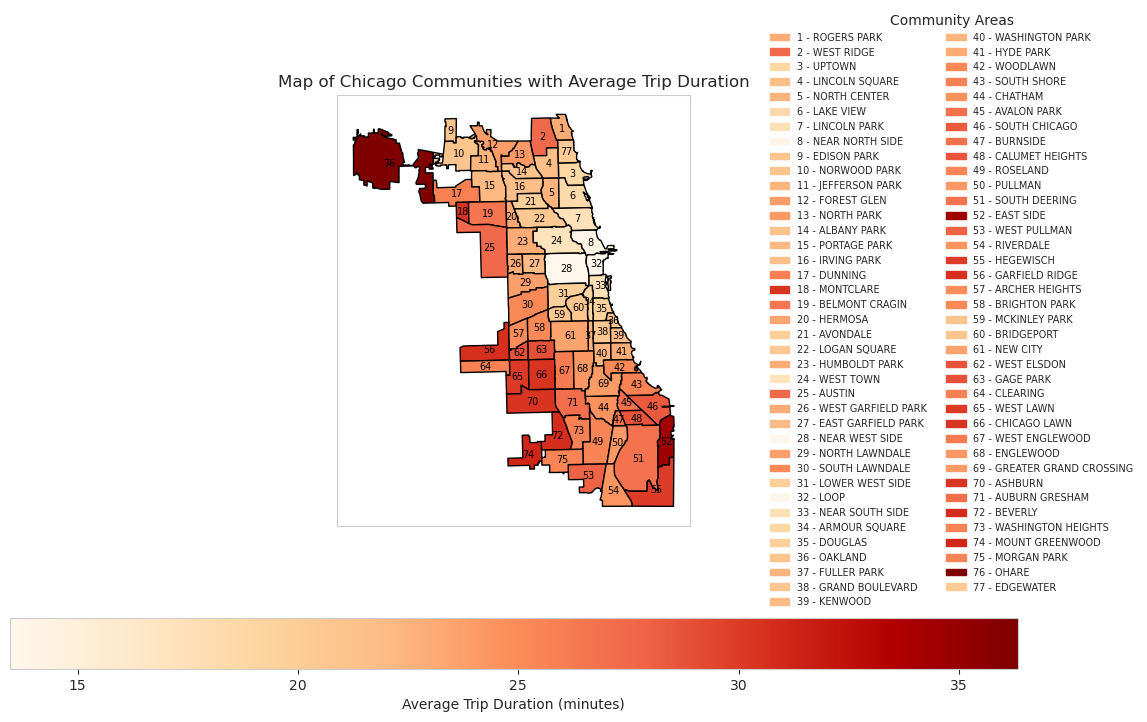

In [296]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.colors as mcolors

# Create figure and axis for plotting
fig1, ax1 = plt.subplots(figsize=(13, 8))

# Plot the communities with light gray color
droff_gdf.plot(
    color="lightgray", 
    edgecolor="black", 
    ax=ax
)

# Add centroids with the area number label
for _, row in droff_gdf.iterrows():
    centroid = row.geometry.centroid
    ax1.text(
        centroid.x, centroid.y,
        str(row["AREA_NUMBER"]),
        fontsize=7,
        color="black",
        ha="center",
        va="center",
    )

# Prepare color mapping for avg_trip_duration (e.g., using a colormap)
cmap1 = plt.cm.OrRd  # You can change the colormap (e.g., 'plasma', 'inferno', etc.)
norm1 = mcolors.Normalize(vmin=droff_gdf['avg_drofftrip_duration'].min(), vmax=droff_gdf['avg_drofftrip_duration'].max())

# Plot each community with color based on avg_trip_duration
droff_gdf.plot(
    column="avg_drofftrip_duration", 
    cmap=cmap1, 
    ax=ax1, 
    legend=True, 
    legend_kwds={'label': "Average Trip Duration (minutes)", 'orientation': "horizontal"},
    norm=norm1,
    edgecolor="black"
)

# Prepare legend handles for community areas with their names and avg_trip_duration
legend_handles = [
    Patch(color=cmap1(norm1(row['avg_drofftrip_duration'])), label=f"{row['AREA_NUMBER']} - {row['COMMUNITY']}") 
    for _, row in droff_gdf.iterrows()
]

# Add the legend with multiple columns
ax1.legend(
    handles=legend_handles,
    title="Community Areas",
    loc="center left",
    bbox_to_anchor=(1.2, 0.5),
    ncol=2,
    fontsize=7,
    title_fontsize=10,
    frameon=False
)

# Add title and axis labels
ax1.set_title("Map of Chicago drop off Communities with Average Trip Duration", fontsize=12)
ax1.set_xticks([])  # Hide X-axis ticks
ax1.set_yticks([])  # Hide Y-axis ticks
ax1.grid(False)

# Show the plot
plt.show()

**----------------------------------------------------------

In [260]:
community_copy_test =  community_areas
speed_test = speed

In [261]:
speed_test = speed_test.withColumnRenamed("pickup_community_area", "AREA_NUMBER")

In [262]:
combined_df_test = speed_test.join(
    community_copy_test,
    speed_test["AREA_NUMBER"] == community_copy_test["AREA_NUMBER"],
    "inner"
).select(
    speed_test["*"],  # Include all columns from taxi_trips
    community_copy_test["COMMUNITY"]
 
)

# Show combined result
combined_df_test.show(10)

+--------------------+--------------------+--------------------+-------------------+----------+-----------+----------------------+-----+-----+-----+------+----------+------------+--------------------+------------+------------------+------------------+
|             trip_id|             taxi_id|trip_start_timestamp| trip_end_timestamp|trip_miles|AREA_NUMBER|dropoff_community_area| fare| tips|tolls|extras|trip_total|payment_type|             company|trip_minutes|         avg_speed|         COMMUNITY|
+--------------------+--------------------+--------------------+-------------------+----------+-----------+----------------------+-----+-----+-----+------+----------+------------+--------------------+------------+------------------+------------------+
|fa08ad43dce297f9d...|b56b3188352442603...| 2023-08-22 21:30:00|2023-08-22 21:45:00|     17.04|         -1|                    -1|43.75|  0.0|  0.0|  27.5|     71.75| Credit Card|            Sun Taxi|          26| 39.32307692307692|Outside of C

In [263]:
from pyspark.sql.functions import avg, col

# Group by community_name and calculate average trip duration
traffic_by_community_test = combined_df_test.groupBy("COMMUNITY","AREA_NUMBER") \
    .agg(avg("trip_minutes").alias("avg_trip_duration")) \
    .orderBy(col("avg_trip_duration").desc())

traffic_by_community_test.show(10)

+--------------+-----------+------------------+
|     COMMUNITY|AREA_NUMBER| avg_trip_duration|
+--------------+-----------+------------------+
|         OHARE|         76| 34.14935821882831|
|       ASHBURN|         70|33.667661752162786|
|     WEST LAWN|         65| 32.75396945410555|
|  CHICAGO LAWN|         66| 31.12667740203972|
|     EAST SIDE|         52|30.970403382470575|
|     MONTCLARE|         18|30.384910485933503|
|     GAGE PARK|         63|30.065845464725644|
|GARFIELD RIDGE|         56|29.400193217157682|
|       BEVERLY|         72| 29.08695652173913|
|   WEST ELSDON|         62| 28.67355458150699|
+--------------+-----------+------------------+
only showing top 10 rows



In [264]:
traffic_by_community_test=traffic_by_community_test.toPandas()
traffic_by_community_test

,COMMUNITY,AREA_NUMBER,avg_trip_duration
0,OHARE,76,34.15
1,ASHBURN,70,33.67
2,WEST LAWN,65,32.75
3,CHICAGO LAWN,66,31.13
4,EAST SIDE,52,30.97
...,...,...,...
73,LAKE VIEW,6,15.77
74,LINCOLN PARK,7,15.49
75,NEAR WEST SIDE,28,13.21
76,NEAR NORTH SIDE,8,12.45


In [265]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Assuming gdf is your original GeoDataFrame of community areas
# Assuming avg_trip_duration_df is the DataFrame with 'AREA_NUMBER' and 'avg_trip_duration'

# Merge avg_trip_duration_df into gdf based on 'AREA_NUMBER'
test_gdf = gdf.merge(traffic_by_community_test[['AREA_NUMBER', 'avg_trip_duration']], on='AREA_NUMBER', how='left')



In [266]:
# Sort GeoDataFrame by AREA_NUMBER (if needed)
#test_gdf["avg_trip_duration"] = test_gdf["avg_trip_duration"].astype(int)
test_gdf.sort_values(by="avg_trip_duration", ascending=False).head(5)




,the_geom,AREA_NUMBER,COMMUNITY,SHAPE_AREA,SHAPE_LEN,geometry,avg_trip_duration
75,MULTIPOLYGON (((-87.83658087874365 41.98639611...,76,OHARE,371835607.687,173625.98466,"MULTIPOLYGON (((-87.83658 41.98640, -87.83658 ...",34.15
69,MULTIPOLYGON (((-87.71254775561886 41.75733733...,70,ASHBURN,135460337.208,54818.1546317,"MULTIPOLYGON (((-87.71255 41.75734, -87.71252 ...",33.67
64,MULTIPOLYGON (((-87.71254775561886 41.75733733...,65,WEST LAWN,82315301.6831,41934.4901309,"MULTIPOLYGON (((-87.71255 41.75734, -87.71278 ...",32.75
65,MULTIPOLYGON (((-87.67815131700259 41.75765952...,66,CHICAGO LAWN,98279465.1151,40073.0998382,"MULTIPOLYGON (((-87.67815 41.75766, -87.67854 ...",31.13
51,MULTIPOLYGON (((-87.52462014976344 41.69180077...,52,EAST SIDE,83241728.0493,52274.1928493,"MULTIPOLYGON (((-87.52462 41.69180, -87.52501 ...",30.97


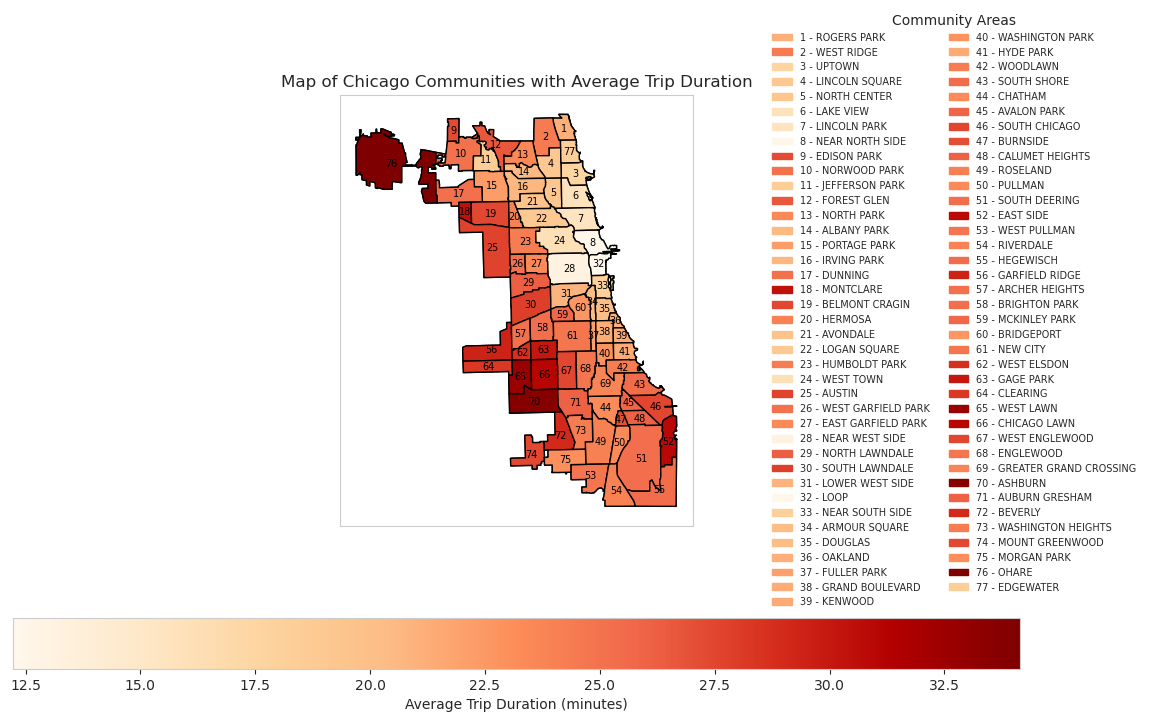

In [267]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.colors as mcolors

# Create figure and axis for plotting
fig, ax = plt.subplots(figsize=(13, 8))

# Plot the communities with light gray color
test_gdf.plot(
    color="lightgray", 
    edgecolor="black", 
    ax=ax
)

# Add centroids with the area number label
for _, row in test_gdf.iterrows():
    centroid = row.geometry.centroid
    ax.text(
        centroid.x, centroid.y,
        str(row["AREA_NUMBER"]),
        fontsize=7,
        color="black",
        ha="center",
        va="center",
    )

# Prepare color mapping for avg_trip_duration (e.g., using a colormap)
cmap = plt.cm.OrRd  # You can change the colormap (e.g., 'plasma', 'inferno', etc.)
norm = mcolors.Normalize(vmin=test_gdf['avg_trip_duration'].min(), vmax=test_gdf['avg_trip_duration'].max())

# Plot each community with color based on avg_trip_duration
test_gdf.plot(
    column="avg_trip_duration", 
    cmap=cmap, 
    ax=ax, 
    legend=True, 
    legend_kwds={'label': "Average Trip Duration (minutes)", 'orientation': "horizontal"},
    norm=norm,
    edgecolor="black"
)

# Prepare legend handles for community areas with their names and avg_trip_duration
legend_handles = [
    Patch(color=cmap(norm(row['avg_trip_duration'])), label=f"{row['AREA_NUMBER']} - {row['COMMUNITY']}") 
    for _, row in test_gdf.iterrows()
]

# Add the legend with multiple columns
ax.legend(
    handles=legend_handles,
    title="Community Areas",
    loc="center left",
    bbox_to_anchor=(1.2, 0.5),
    ncol=2,
    fontsize=7,
    title_fontsize=10,
    frameon=False
)

# Add title and axis labels
ax.set_title("Map of Chicago Pick up Communities with Average Trip Duration", fontsize=12)
ax.set_xticks([])  # Hide X-axis ticks
ax.set_yticks([])  # Hide Y-axis ticks
ax.grid(False)

# Show the plot
plt.show()

## 8. Machine Learning <a class="anchor" id="8"></a>
---

## 9. Conclusion, Challenges, and Future Scope (Need fixing) <a class="anchor" id="9"></a>
---

### 9.1 Conclusion
The analysis of Chicago taxi trips reveals distinct trends in taxi usage across various timeframes. A significant disparity emerges in the volume of taxi rides between downtown Chicago, Chicago O’Hare International Airport, and other areas of the city, highlighting potential hotspots for traffic congestion. Demand is consistently high on weekdays throughout Chicago and cross the years, peaking around 5 PM as commuters leave work.

[Add more as more EDA are added to the notebook]

### 9.2 Challenges
1. **Data Quality:** Some features of the data contains values that are either unrealistics or unintuitive to what they represent. We make decisions to either drop the rows or impute thevalues keeping in mind the amount of data that may be lost.

## Reference
### Code Review and Debugging
We use ChatGPT to suggest ways to improve our Python code, including optimizing algorithms and resolving potential errors.
### Content Generation
We used ChatGPT to brainstorm ideas and structure the initial outline of the project. The AI helped us refine our thesis statement and suggested key points to include in each section.